# Capstone: House Price Prediction

## Data Processing & Modeling

### By: David Blake Hudson

This code file is the second part of this project. The code has been broken down into to notebooks to allowing viewing on Github.


# Data Pre-Processing

I am dropping total_area since it is the sum of living measure and lot measure and has perfect colinearity with lot measure. I am dropping zipcode, yr_built, and yr_renovated since we have alternative variables that are aggregated versions of these to help us reduce the dimensionality of our data and make our model more general.

I transforming all of the categorical variables category data types, but I am transforming sight and room_bed to integer data types because I believe it will be best used as a ordinal variable than in the regression rather than a dummy variable for each value for the variables. However, I have to wait until I impute missing values before I can turn these variables to integers.

In [575]:
# Aggregating month_sold to warm_month_sold
# Used https://www.usclimatedata.com to determine that Nov to Feb are warmer and higher house prices when sold.
df.loc[~df['month_sold'].isin([11,12,1,2]), 'warm_month_sold'] = 1
df['warm_month_sold'].fillna(0, inplace=True)

In [585]:
# Creating a categorical var that represents the avg house price per zipcode2 group binned into 3 groups low, medium, and high.
df_mean = df.groupby(by='zipcode2').mean().round(2)[['price']].reset_index()
for i in df['zipcode2'].unique():
    df.loc[df['zipcode2']==i, 'avg_price_zip'] = df_mean.loc[df_mean['zipcode2']==i,'price'].values[0]

df['zip_price_cat'] = pd.cut(df['avg_price_zip'], bins=3, labels=['low_price','medium_price','high_price'])

In [98]:
# Dropping columns that are not needed
df.drop(columns=['total_area','zipcode','avg_price_zip','month_sold'], inplace=True)

In [99]:
# Converting category columns to categorical data type for encoder to create dummy variables
cols_to_cat = ['year_sold','warm_month_sold','furnished','coast', 'ceil','zip_price_cat']
df[cols_to_cat] = df[cols_to_cat].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21613 entries, 0 to 21612
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   price             21613 non-null  float64 
 1   room_bed          21487 non-null  float64 
 2   room_bath         21495 non-null  float64 
 3   living_measure    21596 non-null  float64 
 4   lot_measure       21571 non-null  float64 
 5   ceil              21541 non-null  category
 6   coast             21582 non-null  category
 7   sight             21556 non-null  float64 
 8   condition         21528 non-null  float64 
 9   quality           21612 non-null  float64 
 10  ceil_measure      21612 non-null  float64 
 11  basement          21612 non-null  float64 
 12  yr_built          21598 non-null  float64 
 13  yr_renovated      21613 non-null  float64 
 14  lat               21613 non-null  float64 
 15  long              21579 non-null  float64 
 16  living_measure15  2144

## Log transformations and outlier detection

First, the continuous variables are plotted one more time and then plotted again after they have undergone the log transformation. Prior to log transformation, extreme values are analyzed to detect any values that appear to be unreasonable outliers that need to be treated.

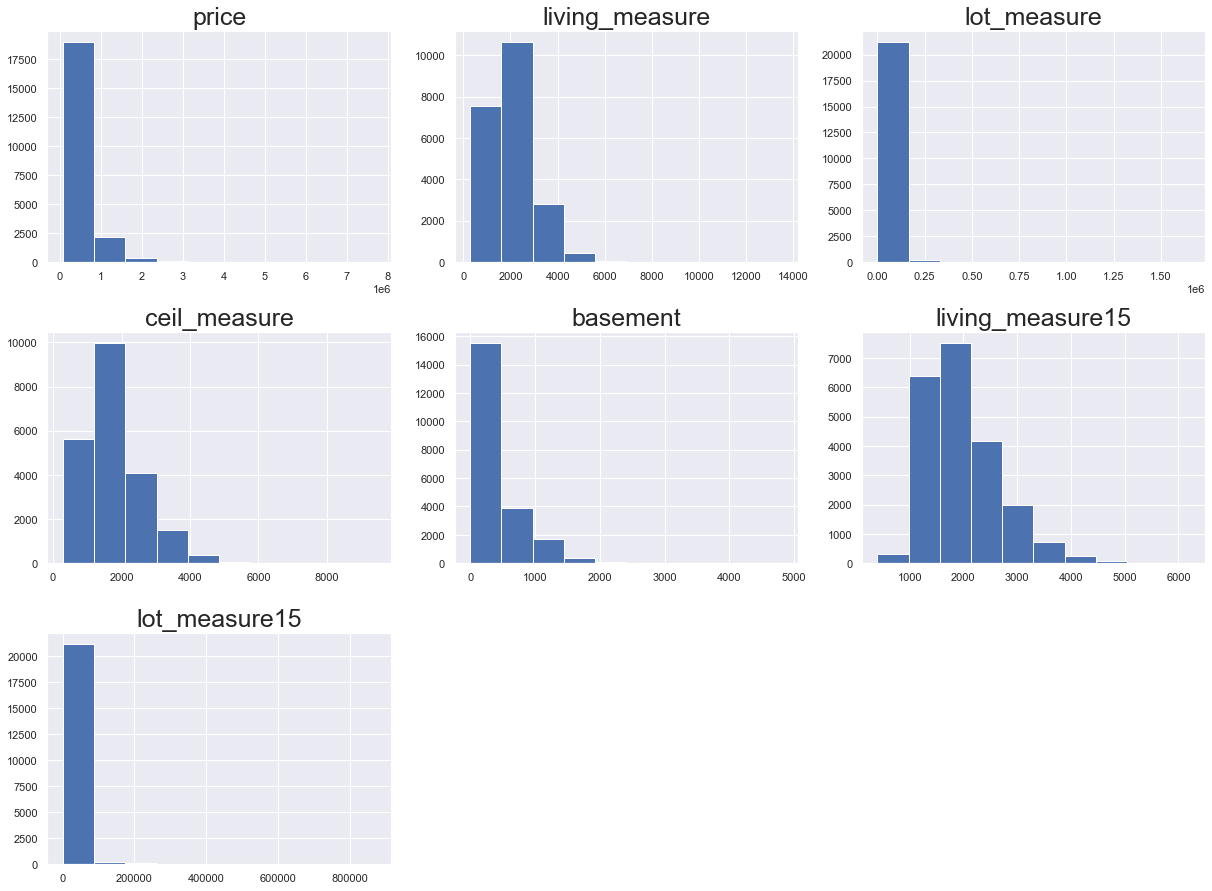

In [100]:
# lets plot histogram of all plots
continuous_vars = ['price','living_measure','lot_measure','ceil_measure','basement','living_measure15',
                  'lot_measure15']

plt.figure(figsize=(17,75))

for i in range(len(continuous_vars)):
    plt.subplot(18,3,i+1)
    plt.hist(df[continuous_vars[i]])
    #sns.displot(df[all_col[i]], kde=True)
    plt.tight_layout()
    plt.title(continuous_vars[i],fontsize=25)
    

plt.show()

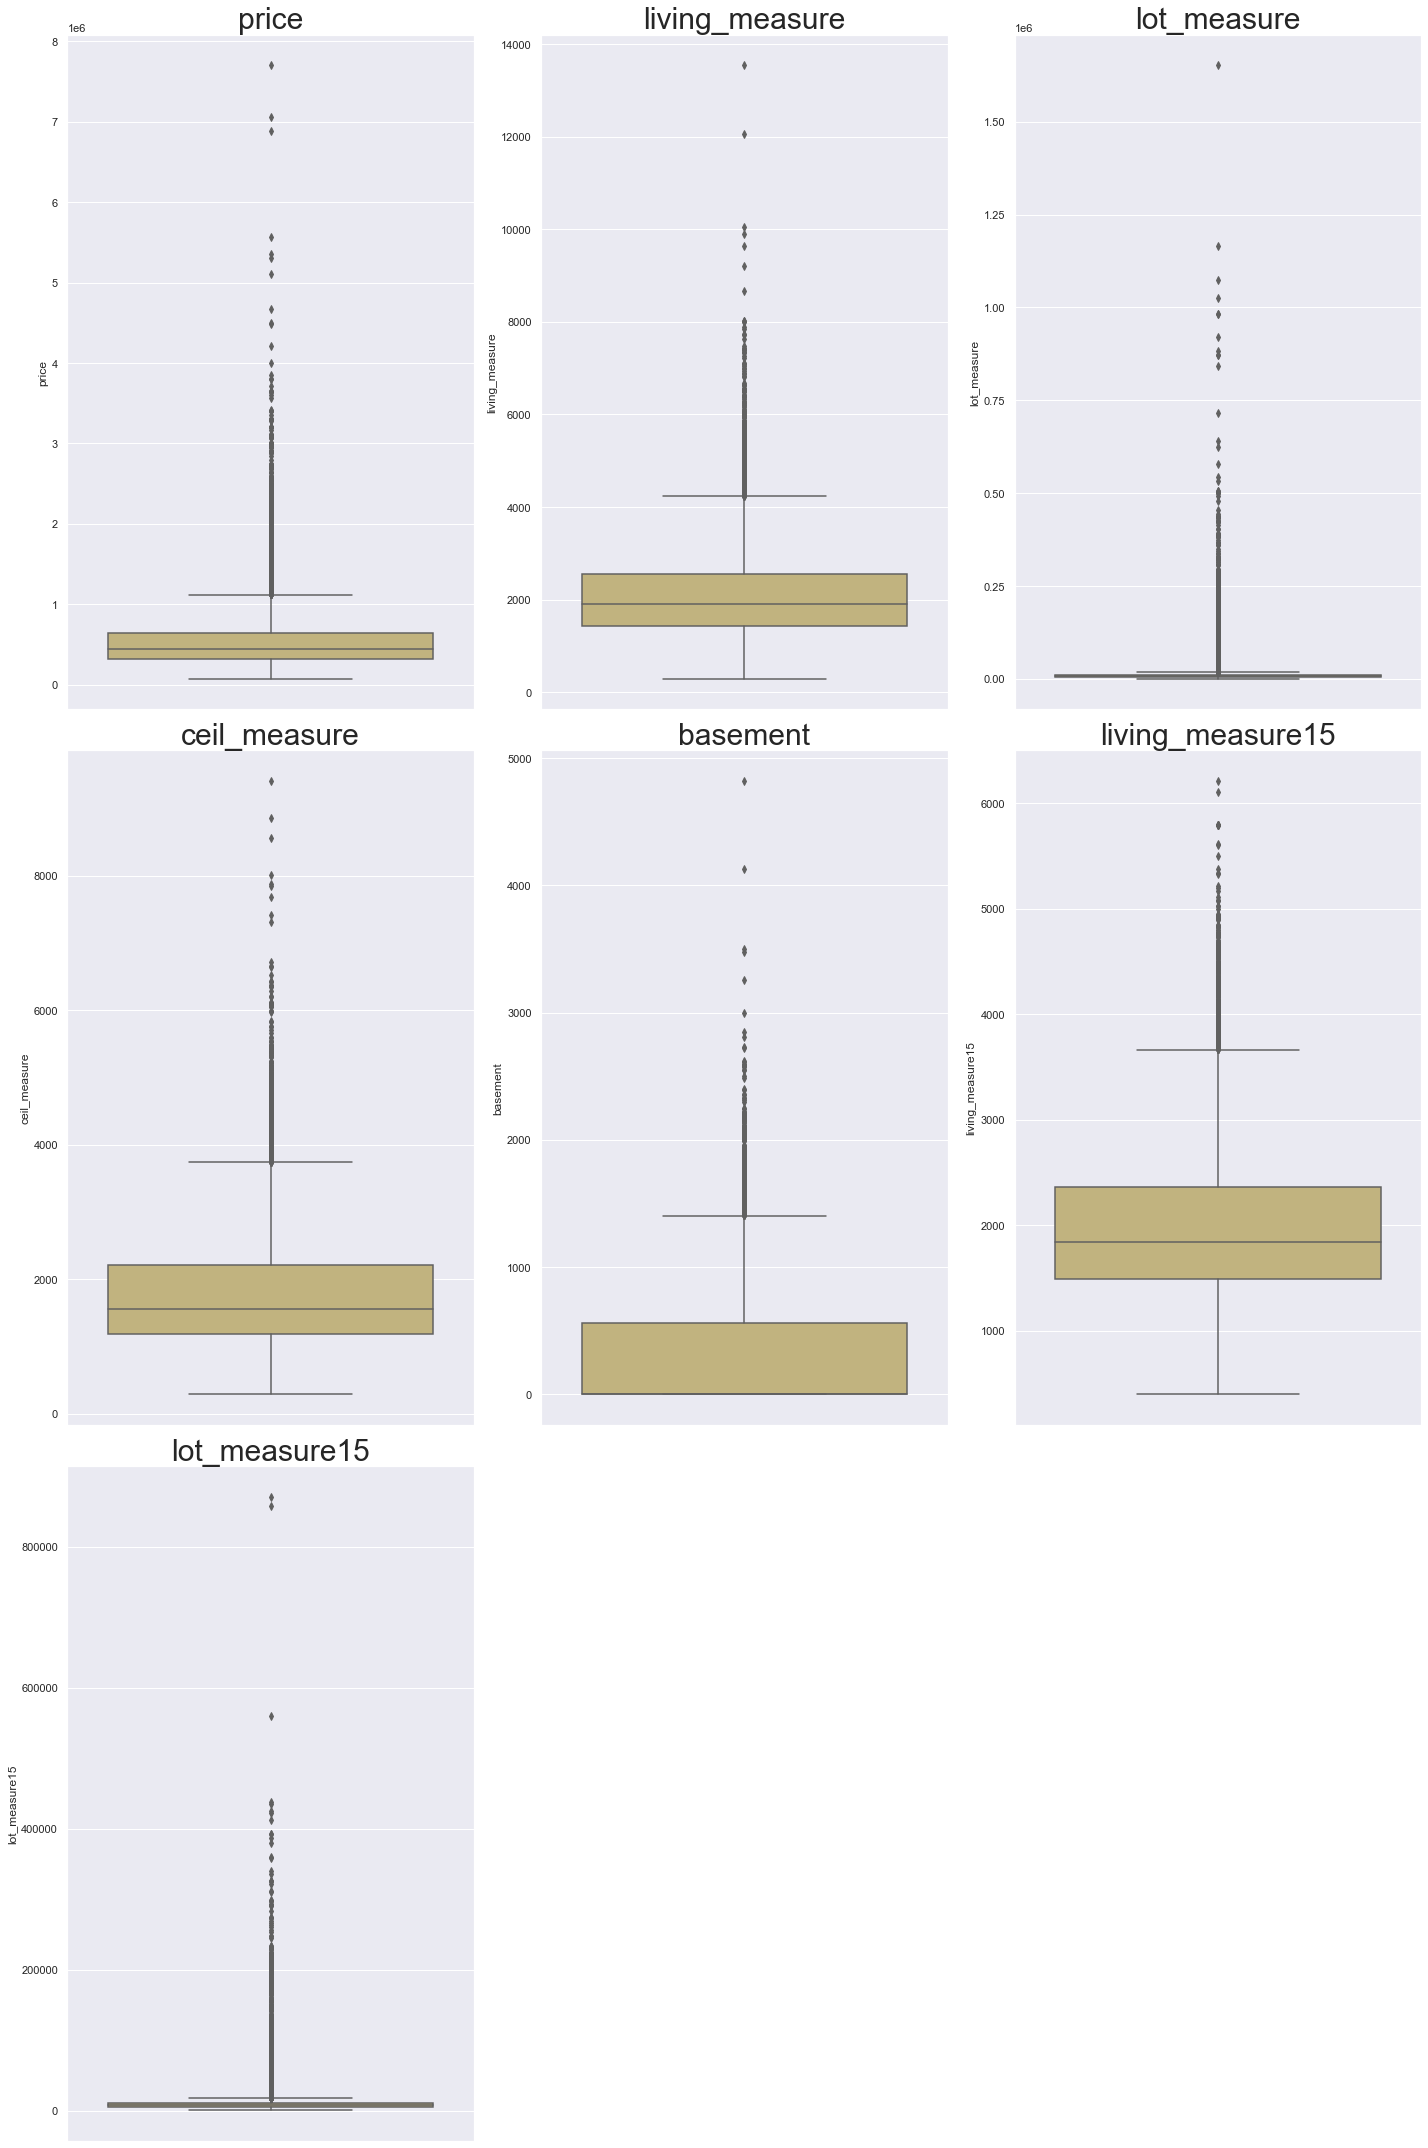

In [101]:
# outlier detection using boxplot
plt.figure(figsize=(20,30))

for i, variable in enumerate(continuous_vars):
                     plt.subplot(3,3,i+1)
                     sns.boxplot(y=df[variable], color = 'y')
                     plt.tight_layout()
                     plt.title(variable,fontsize=30)

plt.show()

In [102]:
# Top 5 price values
top5 = df.loc[df['price'].nlargest(5).index.to_list(),'price'].values # Top 5 price values
df.loc[df['price'].nlargest(5).index.to_list(),:]

,price,room_bed,room_bath,living_measure,lot_measure,ceil,coast,sight,condition,quality,ceil_measure,basement,yr_built,yr_renovated,lat,long,living_measure15,lot_measure15,furnished,year_sold,zipcode2,warm_month_sold,zip_price_cat
1068,7700000.000,6.000,8.000,12050.000,27600.000,2.500,0.000,3.000,4.000,13.000,8570.000,3480.000,1910.000,1987.000,47.630,-122.323,3940.000,8800.000,1.000,2014,9810,1.000,high_price
10718,7060000.000,5.000,4.500,10040.000,37325.000,2.000,1.000,2.000,3.000,11.000,7680.000,2360.000,1940.000,2001.000,47.650,-122.214,3930.000,25449.000,1.000,2014,9800,1.000,high_price
10639,6890000.000,6.000,7.750,9890.000,31374.000,2.000,0.000,4.000,3.000,13.000,8860.000,1030.000,2001.000,0.000,47.630,NaN,4540.000,42730.000,1.000,2014,9803,1.000,medium_price
12794,5570000.000,5.000,5.750,9200.000,35069.000,2.000,0.000,0.000,3.000,13.000,6200.000,3000.000,2001.000,0.000,47.629,-122.233,3560.000,24345.000,1.000,2014,9803,1.000,medium_price
1031,5350000.000,5.000,5.000,8000.000,23985.000,2.000,0.000,4.000,3.000,12.000,6720.000,1280.000,2009.000,0.000,47.623,-122.220,4600.000,21750.000,1.000,2015,9800,1.000,high_price


In [103]:
# Top 5 living measure values
top5 = df.loc[df['living_measure'].nlargest(5).index.to_list(),'living_measure'].values # Top 5 living measure values
df.loc[df['living_measure'].nlargest(5).index.to_list(),:]

,price,room_bed,room_bath,living_measure,lot_measure,ceil,coast,sight,condition,quality,ceil_measure,basement,yr_built,yr_renovated,lat,long,living_measure15,lot_measure15,furnished,year_sold,zipcode2,warm_month_sold,zip_price_cat
7928,2280000.000,7.000,8.000,13540.000,307752.000,3.000,0.000,4.000,3.000,12.000,9410.000,4130.000,1999.000,0.000,47.667,-121.986,4850.000,217800.000,1.000,2014,9805,1.000,medium_price
1068,7700000.000,6.000,8.000,12050.000,27600.000,2.500,0.000,3.000,4.000,13.000,8570.000,3480.000,1910.000,1987.000,47.630,-122.323,3940.000,8800.000,1.000,2014,9810,1.000,high_price
10718,7060000.000,5.000,4.500,10040.000,37325.000,2.000,1.000,2.000,3.000,11.000,7680.000,2360.000,1940.000,2001.000,47.650,-122.214,3930.000,25449.000,1.000,2014,9800,1.000,high_price
10639,6890000.000,6.000,7.750,9890.000,31374.000,2.000,0.000,4.000,3.000,13.000,8860.000,1030.000,2001.000,0.000,47.630,NaN,4540.000,42730.000,1.000,2014,9803,1.000,medium_price
1245,4670000.000,5.000,6.750,9640.000,13068.000,1.000,1.000,4.000,3.000,12.000,4820.000,4820.000,1983.000,2009.000,47.557,-122.210,3270.000,10454.000,1.000,2014,9804,1.000,high_price


In [104]:
# Top 5 lot measure values
top5 = df.loc[df['lot_measure'].nlargest(5).index.to_list(),'lot_measure'].values # Top 5 living measure values
df.loc[df['lot_measure'].nlargest(5).index.to_list(),:]

,price,room_bed,room_bath,living_measure,lot_measure,ceil,coast,sight,condition,quality,ceil_measure,basement,yr_built,yr_renovated,lat,long,living_measure15,lot_measure15,furnished,year_sold,zipcode2,warm_month_sold,zip_price_cat
11674,700000.000,4.000,1.000,1300.000,1651359.000,1.000,0.000,3.000,4.000,6.000,1300.000,0.000,1920.000,0.000,47.231,-122.023,2560.000,425581.000,0.000,2015,9802,1.000,medium_price
580,190000.000,2.000,1.000,710.000,1164794.000,1.000,0.000,0.000,2.000,5.000,710.000,0.000,1915.000,0.000,47.689,-121.909,1680.000,16730.000,0.000,2015,9801,1.000,medium_price
3234,542500.000,5.000,3.250,3010.000,1074218.000,1.500,0.000,0.000,5.000,8.000,2010.000,1000.000,1931.000,0.000,47.456,-122.004,2450.000,68825.000,0.000,2014,9802,1.000,medium_price
21402,855000.000,4.000,3.500,4030.000,1024068.000,2.000,0.000,0.000,3.000,10.000,4030.000,0.000,2006.000,0.000,47.462,-121.744,1830.000,11700.000,1.000,2015,9804,0.000,high_price
5643,998000.000,4.000,3.250,3770.000,982998.000,2.000,0.000,0.000,3.000,10.000,3770.000,0.000,1992.000,0.000,47.414,-122.087,2290.000,37141.000,1.000,2014,9805,1.000,medium_price


In [105]:
# Top 5 basement values
top5 = df.loc[df['basement'].nlargest(5).index.to_list(),'basement'].values # Top 5 living measure values
df.loc[df['basement'].nlargest(5).index.to_list(),:]

,price,room_bed,room_bath,living_measure,lot_measure,ceil,coast,sight,condition,quality,ceil_measure,basement,yr_built,yr_renovated,lat,long,living_measure15,lot_measure15,furnished,year_sold,zipcode2,warm_month_sold,zip_price_cat
1245,4670000.000,5.000,6.750,9640.000,13068.000,1.000,1.000,4.000,3.000,12.000,4820.000,4820.000,1983.000,2009.000,47.557,-122.210,3270.000,10454.000,1.000,2014,9804,1.000,high_price
7928,2280000.000,7.000,8.000,13540.000,307752.000,3.000,0.000,4.000,3.000,12.000,9410.000,4130.000,1999.000,0.000,47.667,-121.986,4850.000,217800.000,1.000,2014,9805,1.000,medium_price
1017,3200000.000,4.000,3.250,7000.000,28206.000,1.000,1.000,4.000,4.000,12.000,3500.000,3500.000,1991.000,0.000,47.593,-122.086,4913.000,14663.000,1.000,2014,9807,1.000,high_price
1068,7700000.000,6.000,8.000,12050.000,27600.000,2.500,0.000,3.000,4.000,13.000,8570.000,3480.000,1910.000,1987.000,47.630,-122.323,3940.000,8800.000,1.000,2014,9810,1.000,high_price
2668,1900000.000,5.000,4.250,6510.000,16471.000,2.000,0.000,3.000,4.000,11.000,3250.000,3260.000,1980.000,0.000,47.576,-122.242,4480.000,16471.000,1.000,2014,9804,1.000,high_price


### Observations
- All of the contintuous variables are heavily skewed and need log transformations.
- Looking at the most extreme outliers for price, the prices seem possible given the number of bed and bathrooms in the house.
- The most extreme outliers for living measure do have many bed and bathrooms as one would expect with large living measure values. Living measure is much larger than the values for living measure15. Maybe rooms were added that ate up the living room space, impossible to verify at this point.
- The most extreme values for lot measure are much larger than the values for lot measure15. Its possible land has been sold off over time.
- For the most extreme values for basement, I do not have the means to verify them.

In [106]:
# Lets treat outliers by flooring and capping
def treat_outliers(dataframe,col_list):
    '''
    treats outliers in a varaible by capping the variables values
    col: str, name of the numerical varaible
    dataframe: data frame
    '''
    data = dataframe.copy()
    for col in col_list:
        Q1=data[col].quantile(0.25) # 25th quantile
        Q3=data[col].quantile(0.75)  # 75th quantile
        IQR=Q3-Q1
        Lower_Whisker = Q1 - 1.5*IQR 
        Upper_Whisker = Q3 + 1.5*IQR
        data[col] = np.clip(data[col], Lower_Whisker, Upper_Whisker) # all the values samller than Lower_Whisker will be assigned value of Lower_whisker 
                                                                # and all the values above upper_whishker will be assigned value of upper_Whisker 
    return data

def log_transform(dataframe,col_list):
    '''
    Performs log transformation on selected variables
    col: str, name of the numerical varaible
    dataframe: data frame
    '''
    data = dataframe.copy()
    for col in col_list:
        if min(data[col]) == 0:
            data[f'log_{col}'] = np.log(data[col]+1) 
        else:
            data[f'log_{col}'] = np.log(data[col])
    return data

As I can rationalize the extreme outliers, I will treat them as values that do represent the process for their respective variables and therefore not cap them. I will only perform log transformation on these variables and check the results

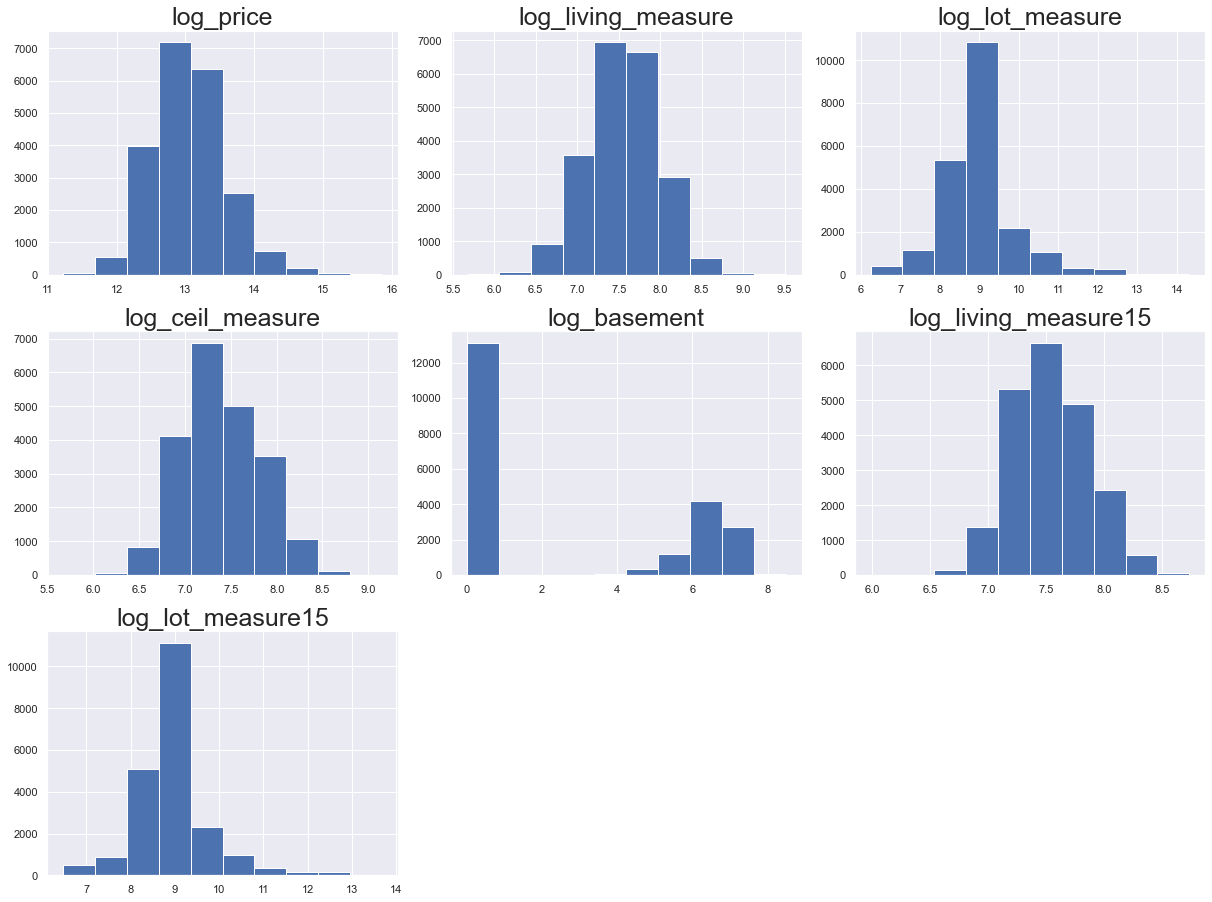

In [107]:
log_con_vars = []
for col in continuous_vars:
    log_con_vars.append(f'log_{col}')

df_log = log_transform(df, continuous_vars)

plt.figure(figsize=(17,75))

for i in range(len(log_con_vars)):
    plt.subplot(18,3,i+1)
    plt.hist(df_log[log_con_vars[i]])
    #sns.displot(df[all_col[i]], kde=True)
    plt.tight_layout()
    plt.title(log_con_vars[i],fontsize=25)
    

plt.show()

### Observations
- Basements log transformation is still heavily skewed. Given the high tails and variance, I think there is a chance that basement is actually a mix of Gaussians. I will create a binned version of this variable as an alternative to try out in the models.

- The rest of the variables are close to being approximately normally distributed after the log transformation.

### Creating binned Basement Category variable

I am binning basement into three categories: those with no basement, those who have a basement and a size this up to 50 percentile among those who have a basement, and then those who have a basement above larger than then 50 percentile. The categories are labeled as No Basement, Small Basement, and Large Basement.

In [108]:
# Getting the smallest basement value that is not equal to 0
df_log.loc[df_log['basement']!=0,'basement'].nsmallest(3)

6709    10.000
16454   10.000
16314   20.000
Name: basement, dtype: float64

In [109]:
# Creating a new variable Basement Category by binning the basement

df_log["basement_category"] = pd.cut(
    x=df_log["basement"],
    bins=[0.0, 10.0, 700.0, np.inf],
    right=False,
    
    labels=["No Basement", "Small Basement", "Large Basement"])

# Confirming the categories are defined as expected. If basement is 0, basement_category should be No Basement and vice versa
print('When basement==0:\n',df_log.loc[df_log['basement']==0, 'basement_category'].value_counts(),'\n')
print('When basement!=0:\n',df_log.loc[df_log['basement']!=0, 'basement_category'].value_counts())

When basement==0:
 No Basement       13125
Small Basement        0
Large Basement        0
Name: basement_category, dtype: int64 

When basement!=0:
 Large Basement    4376
Small Basement    4111
No Basement          0
Name: basement_category, dtype: int64


In [304]:
X = df_log.drop(["price", "log_price",'zipcode2'], axis=1)
Y = df_log[["price", "log_price"]]

In [305]:
def encode_cat_vars(x):
    x = pd.get_dummies(
        x,
        columns=x.select_dtypes(include=["object", "category"]).columns.tolist(),
        drop_first=True)
    return x

In [306]:
null_cat = []
for i in cols_to_cat: 
    if df_log[i].isnull().any() == True: 
        null_cat.append(i)

In [307]:
null_cat

['furnished', 'coast', 'ceil']

In [308]:
X

,room_bed,room_bath,living_measure,lot_measure,ceil,coast,sight,condition,quality,ceil_measure,basement,yr_built,yr_renovated,lat,long,living_measure15,lot_measure15,furnished,year_sold,warm_month_sold,zip_price_cat,log_living_measure,log_lot_measure,log_ceil_measure,log_basement,log_living_measure15,log_lot_measure15,basement_category
0,4.000,1.750,3050.000,9440.000,1.000,0.000,0.000,3.000,8.000,1800.000,1250.000,1966.000,0.000,47.723,-122.183,2020.000,8660.000,0.000,2015,1.000,medium_price,8.023,9.153,7.496,7.132,7.611,9.066,Large Basement
1,2.000,1.000,670.000,3101.000,1.000,0.000,0.000,4.000,6.000,670.000,0.000,1948.000,0.000,47.555,-122.274,1660.000,4100.000,0.000,2015,1.000,high_price,6.507,8.039,6.507,0.000,7.415,8.319,No Basement
2,4.000,2.750,3040.000,2415.000,2.000,1.000,4.000,3.000,8.000,3040.000,0.000,1966.000,0.000,47.519,-122.256,2620.000,2433.000,0.000,2014,1.000,high_price,8.020,7.789,8.020,0.000,7.871,7.797,No Basement
3,3.000,2.500,1740.000,3721.000,2.000,0.000,0.000,3.000,8.000,1740.000,0.000,2009.000,0.000,47.336,-122.213,2030.000,3794.000,0.000,2014,1.000,high_price,7.462,8.222,7.462,0.000,7.616,8.241,No Basement
4,2.000,1.000,1120.000,4590.000,1.000,0.000,0.000,3.000,7.000,1120.000,0.000,1924.000,0.000,47.566,-122.285,1120.000,5100.000,0.000,2015,0.000,high_price,7.021,8.432,7.021,0.000,7.021,8.537,No Basement
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,4.000,2.500,3130.000,60467.000,2.000,0.000,0.000,3.000,9.000,3130.000,0.000,1996.000,0.000,47.662,-121.962,2780.000,44224.000,1.000,2015,1.000,medium_price,8.049,11.010,8.049,0.000,7.930,10.697,No Basement
21609,2.000,1.000,1030.000,4841.000,1.000,0.000,0.000,3.000,7.000,920.000,110.000,1939.000,0.000,47.686,-122.341,1530.000,4944.000,0.000,2014,1.000,high_price,6.937,8.485,6.824,4.710,7.333,8.506,Small Basement
21610,3.000,3.750,3710.000,34412.000,2.000,0.000,0.000,3.000,10.000,2910.000,800.000,1978.000,0.000,47.589,-122.040,2390.000,34412.000,1.000,2014,1.000,high_price,8.219,10.446,7.976,6.686,7.779,10.446,Large Basement
21611,4.000,2.500,1560.000,7800.000,2.000,0.000,0.000,3.000,7.000,1560.000,0.000,1997.000,0.000,47.514,-122.316,1160.000,7800.000,0.000,2015,0.000,low_price,7.352,8.962,7.352,0.000,7.056,8.962,No Basement


In [309]:
# Encoding categorical vars
ind_vars_num = encode_cat_vars(X)
for i in df_log.columns[df_log.isnull().any()].to_list():
    ind_vars_num.loc[df_log[i].isnull(), ind_vars_num.columns.str.startswith(f"{i}_")] = np.nan
    
ind_vars_num.head()

,room_bed,room_bath,living_measure,lot_measure,sight,condition,quality,ceil_measure,basement,yr_built,yr_renovated,lat,long,living_measure15,lot_measure15,log_living_measure,log_lot_measure,log_ceil_measure,log_basement,log_living_measure15,log_lot_measure15,ceil_1.5,ceil_2.0,ceil_2.5,ceil_3.0,ceil_3.5,coast_1.0,furnished_1.0,year_sold_2015,warm_month_sold_1.0,zip_price_cat_medium_price,zip_price_cat_high_price,basement_category_Small Basement,basement_category_Large Basement
0,4.000,1.750,3050.000,9440.000,0.000,3.000,8.000,1800.000,1250.000,1966.000,0.000,47.723,-122.183,2020.000,8660.000,8.023,9.153,7.496,7.132,7.611,9.066,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,1,1,0,0.000,1.000
1,2.000,1.000,670.000,3101.000,0.000,4.000,6.000,670.000,0.000,1948.000,0.000,47.555,-122.274,1660.000,4100.000,6.507,8.039,6.507,0.000,7.415,8.319,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,1,0,1,0.000,0.000
2,4.000,2.750,3040.000,2415.000,4.000,3.000,8.000,3040.000,0.000,1966.000,0.000,47.519,-122.256,2620.000,2433.000,8.020,7.789,8.020,0.000,7.871,7.797,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0,1,0,1,0.000,0.000
3,3.000,2.500,1740.000,3721.000,0.000,3.000,8.000,1740.000,0.000,2009.000,0.000,47.336,-122.213,2030.000,3794.000,7.462,8.222,7.462,0.000,7.616,8.241,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0,1,0,1,0.000,0.000
4,2.000,1.000,1120.000,4590.000,0.000,3.000,7.000,1120.000,0.000,1924.000,0.000,47.566,-122.285,1120.000,5100.000,7.021,8.432,7.021,0.000,7.021,8.537,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,0,0,1,0.000,0.000


In [310]:
ind_vars_num.isna().sum()

room_bed                            126
room_bath                           118
living_measure                       17
lot_measure                          42
sight                                57
condition                            85
quality                               1
ceil_measure                         72
basement                              1
yr_built                             15
yr_renovated                          0
lat                                   0
long                                 34
living_measure15                    166
lot_measure15                        29
log_living_measure                   17
log_lot_measure                      42
log_ceil_measure                      1
log_basement                          1
log_living_measure15                166
log_lot_measure15                    29
ceil_1.5                             72
ceil_2.0                             72
ceil_2.5                             72
ceil_3.0                             72


### Imputing missing variables
Splitting the data into training and testing data prior to imputation to avoid data leak of test data information to train data and biasing our model.

In [492]:
from sklearn.model_selection import train_test_split # Splitting data into train and test data

x_train, x_test, y_train, y_test = train_test_split(ind_vars_num, Y, test_size=0.3, random_state=1)

In [493]:
# defining function for imputing missing values using KNN
def imputation(data):
    mm = MinMaxScaler() # for standardizing variables prior to imputation
    data2 = data.copy()

    sca = mm.fit_transform(data2) # standardizing data
    knn_imputer = KNNImputer()
    knn = knn_imputer.fit_transform(sca)
    data2.iloc[:,:] = mm.inverse_transform(knn) # returning to original data
    
    return data2

In [494]:
x_train_im = imputation(x_train) #imputing missing values for training dataset
x_test_im = imputation(x_test) #imputing missing values for testing dataset
# Rounding floats to integers. 
# Rounding to whole numbers except for log transformed variables as the other float vars (bathroom & ceil) are dummy vars now
x_train_im[x_train_im.columns[~pd.Series(x_train_im.columns).str.startswith('log')]] = round(
    x_train_im[x_train_im.columns[~pd.Series(x_train_im.columns).str.startswith('log')]])
x_train_im[x_train_im.columns[~pd.Series(x_train_im.columns).str.startswith('log')]] = round(
    x_train_im[x_train_im.columns[~pd.Series(x_train_im.columns).str.startswith('log')]])

In [495]:
# Checking training data's unique values to make sure they match expectations after imputation and rounding
columns = x_train_im.columns
for col in columns:
    print('Unique Values of {} are \n'.format(col),x_train_im[col].unique())
    print('*'*100)

Unique Values of room_bed are 
 [2. 3. 4. 5. 1. 6. 7. 8. 9.]
****************************************************************************************************
Unique Values of room_bath are 
 [2. 1. 3. 4. 5. 6. 8. 0. 7.]
****************************************************************************************************
Unique Values of living_measure are 
 [ 1830.  1380.  1130.  1820.  1660.  4890.  3860.  2830.  1630.  2120.
  1560.  1200.  2960.  2100.  2450.  2160.  1810.  2000.  1940.  3400.
  2620.  1260.  3780.  5230.  3800.   390.  1930.  2670.  2340.   750.
  3700.  2590.  4060.  2140.  2840.  1240.  2310.  1070.  2110.  1740.
  2380.  1520.  2480.  2200.  4040.  1870.  1600.  1760.  1280.  1370.
  1970.  1150.  1920.  2790.  2910.  2320.  2580.  2980.  2300.  1010.
  2260.  1080.  3790.  3050.  4420.  1270.  1300.  2190.  3510.  2060.
  2540.  1950.  5570.  1350.  2350.  3270.  2630.  1610.  1710.  2940.
  1190.  2820.  2434.  1290.  3100.  1340.  1050.  3550.  1500.  2410

In [496]:
# Checking testing data's unique values to make sure they match expectations after imputation and rounding
columns = x_test_im.columns
for col in columns:
    print('Unique Values of {} are \n'.format(col),x_test_im[col].unique())
    print('*'*100)

Unique Values of room_bed are 
 [3.  4.  2.  3.4 5.  3.6 6.  3.2 3.8 1.  8.  7.  2.8 2.2 9.  4.2 5.4]
****************************************************************************************************
Unique Values of room_bath are 
 [2.75 2.5  1.   3.5  2.   1.75 1.5  2.45 2.25 0.75 3.   3.25 4.5  4.75
 3.75 5.25 5.   4.   6.   1.4  1.1  4.25 1.7  5.5  1.6  5.75 0.5  2.45
 1.55 2.55 1.85 1.15 1.3  1.9  2.3  2.05 6.25 3.65 1.65 3.25]
****************************************************************************************************
Unique Values of living_measure are 
 [1950. 2340. 3360. 2310.  800. 1320. 3600. 1540. 1130. 2430. 1240. 1920.
 1410.  950. 1390. 1870. 1330. 2290. 2300. 1480. 1280. 2460. 1580. 1670.
  780. 1880. 1610. 1300. 1820. 2020. 2560. 1940. 2060.  830. 2130. 2470.
 2410. 1680. 1890. 2570. 1930. 1070. 1190. 3040. 3290. 1010. 1740. 2090.
  810. 1760. 2360. 1600. 1660. 4570. 1530. 2390. 1990. 2680. 3370. 1960.
 3030. 1230.  880. 1490. 5120. 2320. 2210. 2440. 2990. 1

In [497]:
# Creating interaction terms for training and testing datasets

# interacting furnished with ceil_measure
x_train_im['furnished_log_ceil_measure'] = x_train_im['furnished_1.0']*x_train_im['log_ceil_measure']
x_test_im['furnished_log_ceil_measure'] = x_test_im['furnished_1.0']*x_test_im['log_ceil_measure']
# interacting furnished with living_measure
x_train_im['furnished_log_living_measure'] = x_train_im['furnished_1.0']*x_train_im['log_living_measure']
x_test_im['furnished_log_living_measure'] = x_test_im['furnished_1.0']*x_test_im['log_living_measure']
# interacting furnished with living_measure15
x_train_im['furnished_log_living_measure15'] = x_train_im['furnished_1.0']*x_train_im['log_living_measure15']
x_test_im['furnished_log_living_measure15'] = x_test_im['furnished_1.0']*x_test_im['log_living_measure15']

# interacting ceil with ceil_measure
for i in df['ceil'].dropna().unique().to_list():
    if i!= df_log['ceil'].dropna().unique().sort_values().to_list()[0]: #avoiding dummy trap
        x_train_im[f'ceil_{i}_log_ceil_measure15'] = x_train_im[f'ceil_{i}']*x_train_im['log_ceil_measure']
        x_test_im[f'ceil_{i}_log_ceil_measure15'] = x_test_im[f'ceil_{i}']*x_test_im['log_ceil_measure']

# Creating interactions between each ceil and basement categories. Using a for loop since there are so many to make
for i in df['ceil'].dropna().unique().to_list():
    if i!= df_log['ceil'].dropna().unique().sort_values().to_list()[0]:
        for j in df_log['basement_category'].dropna().unique().to_list():
            if j != df_log['basement_category'].dropna().unique().sort_values().to_list()[0]: #avoiding dummy trap
                x_train_im[f'ceil_{i}_{j}'] = x_train_im[f'ceil_{i}']*x_train_im[f'basement_category_{j}']
                x_test_im[f'ceil_{i}_{j}'] = x_test_im[f'ceil_{i}']*x_test_im[f'basement_category_{j}']
                
x_train_im.head(5)

,room_bed,room_bath,living_measure,lot_measure,sight,condition,quality,ceil_measure,basement,yr_built,yr_renovated,lat,long,living_measure15,lot_measure15,log_living_measure,log_lot_measure,log_ceil_measure,log_basement,log_living_measure15,log_lot_measure15,ceil_1.5,ceil_2.0,ceil_2.5,ceil_3.0,ceil_3.5,coast_1.0,furnished_1.0,year_sold_2015,warm_month_sold_1.0,zip_price_cat_medium_price,zip_price_cat_high_price,basement_category_Small Basement,basement_category_Large Basement,furnished_log_ceil_measure,furnished_log_living_measure,furnished_log_living_measure15,ceil_2.0_log_ceil_measure15,ceil_3.0_log_ceil_measure15,ceil_1.5_log_ceil_measure15,ceil_2.5_log_ceil_measure15,ceil_3.5_log_ceil_measure15,ceil_2.0_Large Basement,ceil_2.0_Small Basement,ceil_3.0_Large Basement,ceil_3.0_Small Basement,ceil_1.5_Large Basement,ceil_1.5_Small Basement,ceil_2.5_Large Basement,ceil_2.5_Small Basement,ceil_3.5_Large Basement,ceil_3.5_Small Basement
2060,2.000,2.000,1830.000,2856.000,0.000,3.000,7.000,1830.000,0.000,2005.000,0.000,48.000,-122.000,1850.000,2667.000,7.512,7.957,7.512,0.000,7.523,7.889,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,7.512,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
11759,2.000,1.000,1380.000,5820.000,0.000,3.000,7.000,1380.000,0.000,1918.000,1976.000,48.000,-122.000,1540.000,4076.000,7.230,8.669,7.230,0.000,7.340,8.313,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
8274,2.000,1.000,1130.000,6908.000,0.000,3.000,6.000,1130.000,0.000,1945.000,0.000,48.000,-122.000,1150.000,6908.000,7.030,8.840,7.030,0.000,7.048,8.840,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,7.030,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
21272,3.000,2.000,1820.000,13362.000,0.000,3.000,8.000,1220.000,600.000,1977.000,0.000,48.000,-122.000,2050.000,15000.000,7.507,9.500,7.107,6.399,7.626,9.616,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
14328,3.000,2.000,1660.000,7221.000,0.000,3.000,7.000,980.000,680.000,1962.000,0.000,47.000,-122.000,1770.000,8083.000,7.415,8.885,6.888,6.524,7.479,8.998,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


# Explatory Data Analysis for new variables

Analyzing the new variables created.

# Univariate Analysis

## Basement Categories

Using the data from before split and imputation for this one since these became their own dummy variables

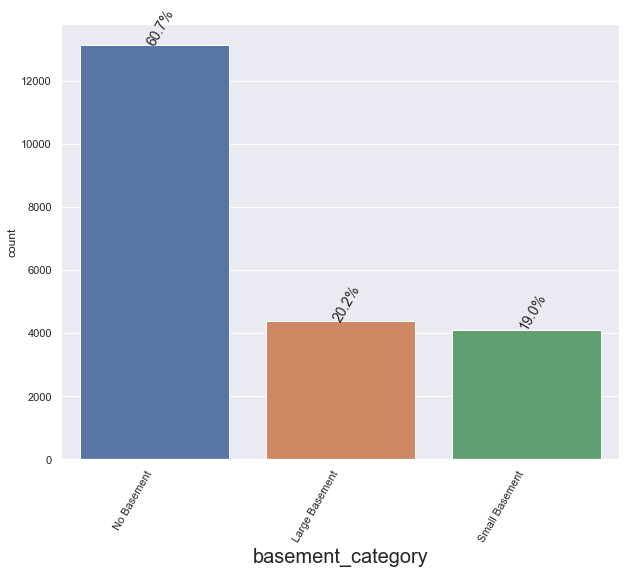

In [373]:
countplot(df_log['basement_category'], order = True, rotation = 60, rotation_perc = 60)

### Observations
- Most houses (60.7%) did not have a bestment.
- There is an approximately equal amount of homes that have large or small basements, but that is a product of how the variable was created (split evenly among those with a basement).

The rest of the variables were created after splitting splitting and imputing the variable. So for exploratory purposes, I rejoined the train and test data together in another df and then added back in log_price so that we could get an overall picture.

## Log Price

 The mean and median for log_price are 13.047886092909524 and 13.017002861746503, respectively.
 There are 52 below the lower whisker and 282 above the upper whisker.


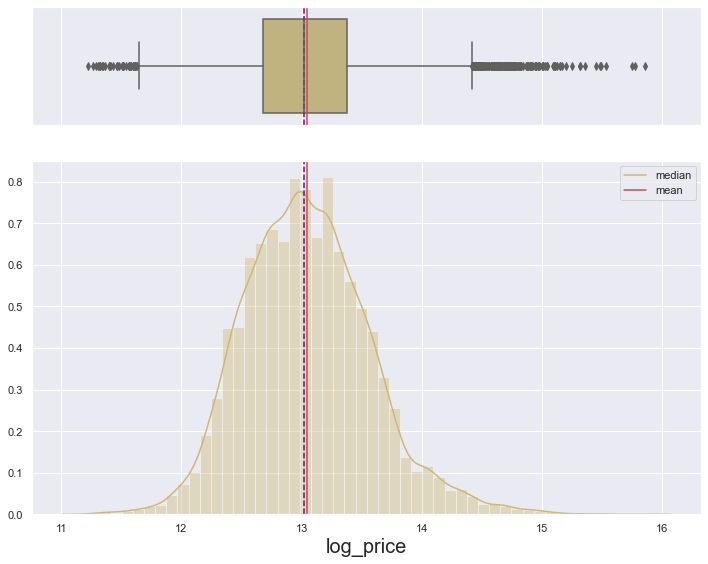

In [296]:
x_EDA = pd.concat([x_train_im,x_test_im]).sort_index()
x_EDA = pd.concat([x_EDA,Y[['log_price']]], axis=1)
quantplot(x_EDA['log_price'])

### Observations
- The mean and median for log_price are 13.05 and 13.02, respectively.
- The log price distribution is approximately normally distributed.

## Log Living Measure

 The mean and median for log_living_measure are 7.550319698479891 and 7.554858521040676, respectively.
 There are 54 below the lower whisker and 61 above the upper whisker.


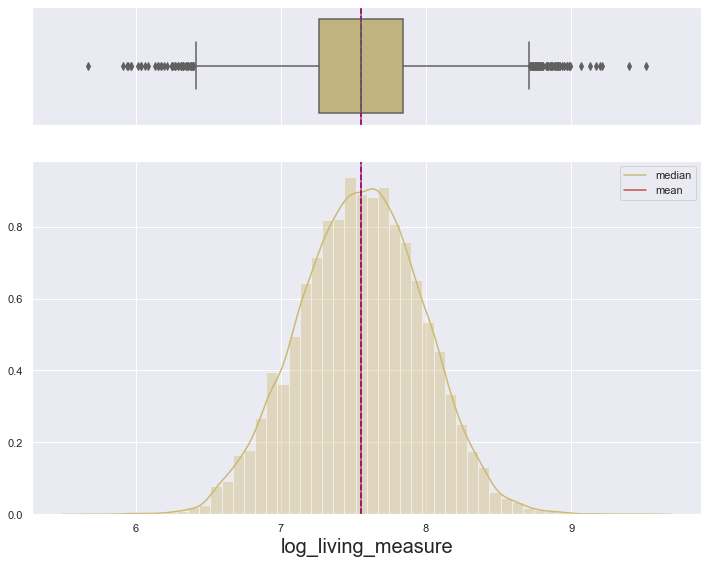

In [297]:
quantplot(x_EDA.log_living_measure)

### Observations
- The mean and median for log_living_measure are 7.55 and 7.55, respectively.
- The logged distribution is approximately normally distributed.

## Log Living Measure15

 The mean and median for log_living_measure15 are 7.539449042519315 and 7.517520850603031, respectively.
 There are 22 below the lower whisker and 55 above the upper whisker.


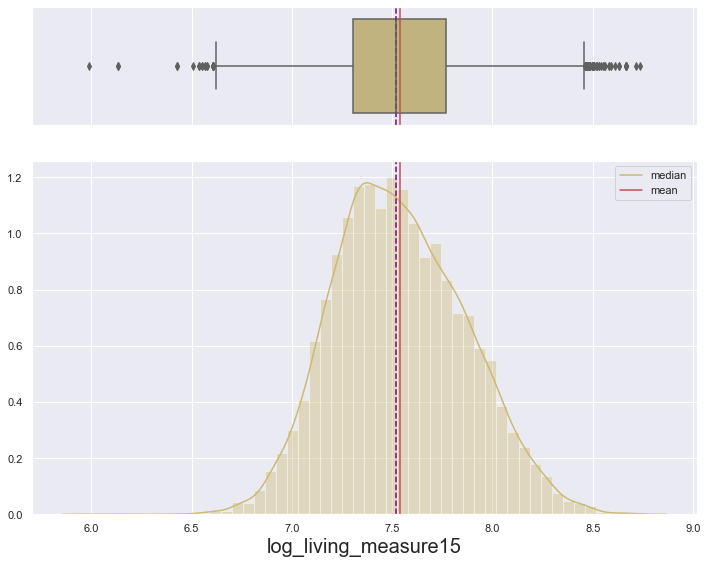

In [298]:
quantplot(x_EDA.log_living_measure15)

### Observations
- The mean and median for log_living_measure15 are 7.54 and 7.52, respectively.
- The log distribution is approximately normally distributed.

## Log Lot Measure

 The mean and median for log_lot_measure are 8.989972620173079 and 8.938531648680692, respectively.
 There are 971 below the lower whisker and 1574 above the upper whisker.


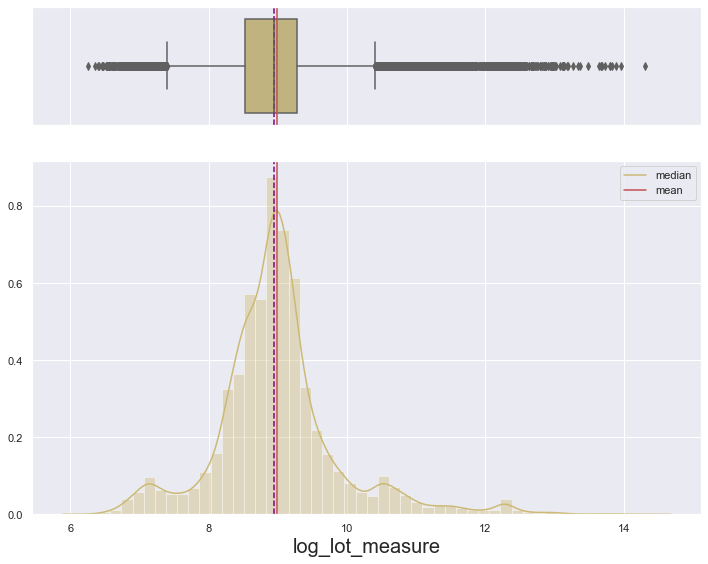

In [299]:
quantplot(x_EDA.log_lot_measure)

### Observations
- The mean and median for log_lot_measure are 8.99 and 8.94, respectively.
- The logged distriution is approximately normally distributed.

## Log Lot Measure15

 The mean and median for log_lot_measure15 are 8.960894813760625 and 8.938531648680692, respectively.
 There are 978 below the lower whisker and 1500 above the upper whisker.


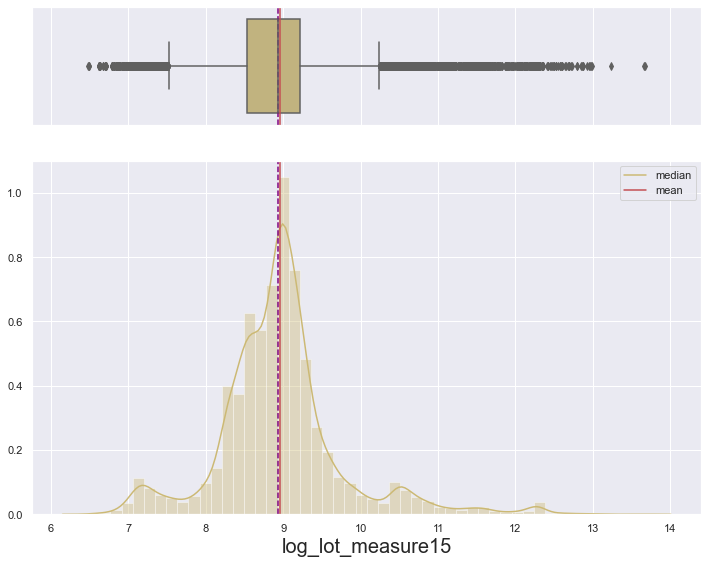

In [128]:
quantplot(x_EDA.log_lot_measure15)

### Observations
- The mean and median for log_lot_measure15 are 8.96 and 8.94, respectively.
- The logged distriution is approximately normally distributed.

## Log Ceil Measure

 The mean and median for log_ceil_measure are 7.394864524821295 and 7.352441100243582, respectively.
 There are 11 below the lower whisker and 39 above the upper whisker.


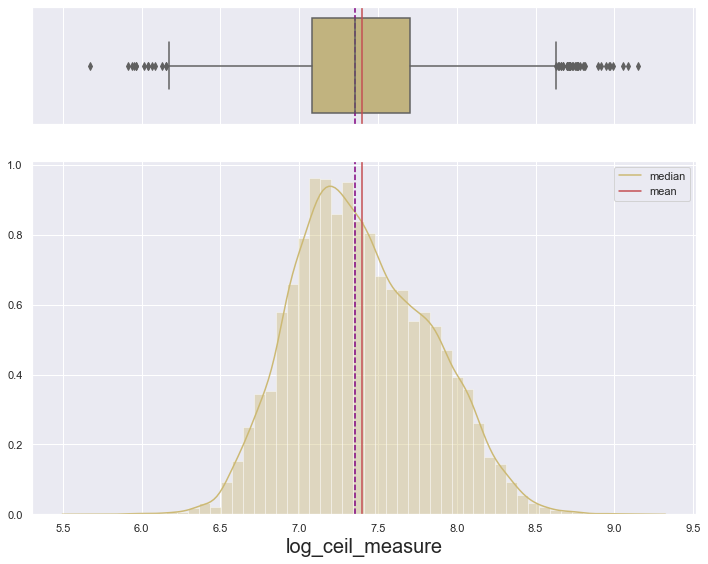

In [129]:
quantplot(x_EDA.log_ceil_measure)

### Observations
- The mean and median for log_ceil_measure are 7.39 and 7.35, respectively.
- The logged distribution is approximately normally distributed.

## Log Basement

 The mean and median for log_basement are 2.529417164246639 and 0.0, respectively.
 There are 0 below the lower whisker and 0 above the upper whisker.


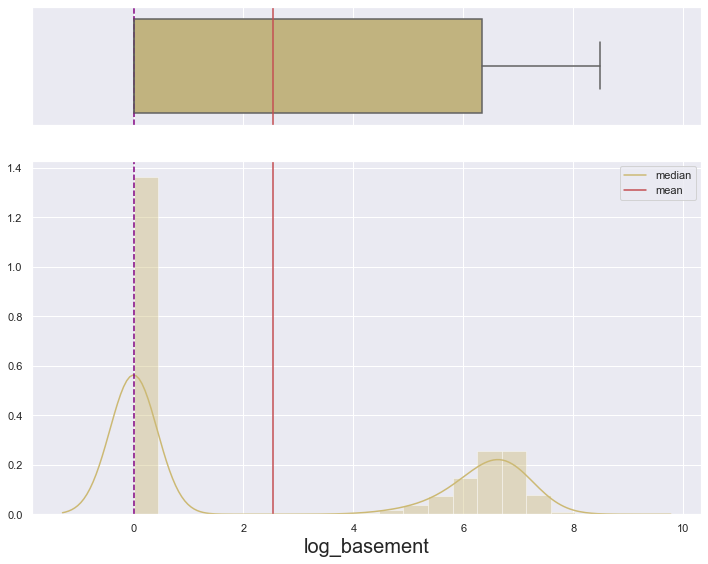

In [130]:
quantplot(x_EDA.log_basement)

### Observations
- The mean and median for log_basement are 2.53 and 0, respectively.
- The log distribution is still heavily negatively skewed.

# Data Processing EDA Conclusion

Except for log basement, all continuous variables are now approximately normally distributed after log transformation. Basement has been binned into 3 categories in case basement's skewed distribution is the results of a mix of Gaussians. Interaction terms have been created for combinations of furnished with log_ceil_measure, and both log_living_measures and combinations of ceil and the different basement categories. I have kept the original variables that have been transformed to be used for the algorithms that use regression trees and do not require the target variable and predictors to be normally distributed.

# Supervised Learning Models

The following block of code creates a function 'checking_vif' to measure the VIF score, the next block of code creates the function 'get_model_score' that reports multiple metrics (RMSE, MAPE, MAE, Economic Cost) to help us evaluate the different models.

Along with the usual metrics to evaluate the models, an additional metric Economic Cost is added to give an additional perspective of the model. If we assume that a house does not sell if it is overpriced, we can consider that as an opportunity cost of not selling the home. Additionally, an underpriced home will sell at a discount, and we can consider the lost potential revenue between what the house could have sold for and what the house sold for is as an opportunity cost as well. Economic Cost is defined as mean of the sum of the sell price for a house our model overpriced and the residual of a house that we underpriced. This metric will be biased against the houses we overpriced since we give greater weight to the house that we overpriced than the one we underpriced.

In [317]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


def checking_vif(train):
    vif = pd.DataFrame()
    vif["feature"] = train.columns

    # calculating VIF for each feature
    vif["VIF"] = [
        variance_inflation_factor(train.values, i) for i in range(len(train.columns))
    ]
    return vif


# print(checking_vif(x_train))

In [705]:
# Function needed later to undo the normalization

def inv_transformation(feature_transformed, log=False, normalized=False, source=None):
    """
    input the standard normal scaled target feature as an array 
    output the same array without the standard normal scale
    """
    

        
    if normalized==True:

        mu = source.mean().values
        sd = source.std().values
            
        feature_transformed = sd*feature_transformed + mu
        
    if log==True:
        feature_transformed = np.exp(feature_transformed)
        
    return feature_transformed

##  Function to calculate r2_score and RMSE on train and test data
def get_model_score(Y_train,Y_test,p_train=None,p_test=None,flag=True,mean=False,df_mean=None,mean_target=None,mean_X=None):
    '''
    model : classifier to predict values of X
    
    mean: flag that tells the function that we want to compute a conditional mean model. 
    If used, only df_mean,mean_target, and mean_x and Y vectors are needed.
    
    df_mean: df to use for conditional mean model
    mean_target: target for var for conditional mean model
    mean_X: conditional var for conditional mean model
    
    log_n_scale= flag for whether to use inv_log_normalize_price function that reverses
    scaling and log transformations, in that order.
    '''

    if mean==True:
        if (mean_target==None) or (mean_X==None):
            raise ValueError('df_mean, mean_target, and mean_target are required if mean argument is True')
        else:
            pred_train = df_mean.loc[(Y_train.index), [mean_target,mean_X]] # Using df_log bc zipcodes are not dummy vars in df
            pred_test = df_mean.loc[(Y_test.index), [mean_target,mean_X]]


            for i in pred_train.zipcode2.unique():
                pred_train.loc[pred_train['zipcode2']==i, 'pred'] = pred_train.loc[pred_train[mean_X]==i, mean_target].mean()
            pred_train['resid'] = pred_train[mean_target] - pred_train['pred']

            for i in pred_train.zipcode2.unique():
                pred_test.loc[pred_test[mean_X]==i, 'pred'] = pred_train.loc[pred_train[mean_X]==i, mean_target].mean()
            pred_test['resid'] = pred_test[mean_target] - pred_test['pred']
            
            Y_train = pred_train[mean_target].copy()
            p_train = pred_train['resid']
            Y_test = pred_test[mean_target].copy()
            p_test = pred_test['resid'].copy()
    
    # Calcutating economic cost    
    for i in range(2):
        if i ==0: 
            values = pd.concat([Y_train, pd.DataFrame(p_train, index=y_train.index)],axis=1)
            values['residual'] = values.iloc[:,0] - values.iloc[:,1]
            values.loc[values['residual']>0, 'Economic Cost'] = values.loc[values['residual']>0, 'residual']
            values.loc[values['residual']<0, 'Economic Cost'] = values.iloc[:,0]
            economic_train = values['Economic Cost'].mean()

        else:
            values = pd.concat([Y_test, pd.DataFrame(p_test, index=y_test.index)],axis=1)     
            values['residual'] = values.iloc[:,0] - values.iloc[:,1]
            values.loc[values['residual']>0, 'Economic Cost'] = values.loc[values['residual']>0, 'residual']
            values.loc[values['residual']<0, 'Economic Cost'] = values.iloc[:,0]
            economic_test = values['Economic Cost'].mean()

    
    train_r2=metrics.r2_score(Y_train,p_train)
    test_r2=metrics.r2_score(Y_test,p_test)

    train_rmse=np.sqrt(metrics.mean_squared_error(Y_train,p_train))
    test_rmse=np.sqrt(metrics.mean_squared_error(Y_test,p_test))

    train_mae=np.sqrt(metrics.mean_absolute_error(Y_train,p_train))
    test_mae=np.sqrt(metrics.mean_absolute_error(Y_test,p_test))

    train_mape=np.sqrt(metrics.mean_absolute_percentage_error(Y_train,p_train))
    test_mape=np.sqrt(metrics.mean_absolute_percentage_error(Y_test,p_test))
    
    # defining an empty list to store train and test results
    score_list=[] 
    #Adding all scores in the list
    score_list.extend((train_r2,test_r2,train_rmse,test_rmse,train_mae,test_mae,train_mape,test_mape,economic_train,economic_test))
    
    # If the flag is set to True then only the following print statements will be dispayed, the default value is True
    if flag==True: 
        print("R-sqaure on training set : ",train_r2)
        print("R-square on test set : ",test_r2)
        print("RMSE on training set : ",train_rmse)
        print("RMSE on test set : ",test_rmse)
        print("MAE on training set : ",train_mae)
        print("MAE on test set : ",test_mae)
        print("MAPE on training set : ",train_mape)
        print("MAPE on test set : ",test_mape)
        print("Economic Cost on training set : ",economic_train)
        print("Economic Cost on test set : ",economic_test)
    
    # returning the list with train and test scores
    return score_list

## Function to store list of metrics to compare models

# defining empty lists to add train and test results
r2_train = []
r2_test = []
rmse_train= []
rmse_test= []
mae_train= []
mae_test= []
mape_train= []
mape_test= []
econ_train= []
econ_test= []

def store_metrics(metrics_output):
# Adding the error metrics and r2 scores to their respetive lists
        # accuracy score
    r2_train.append(metrics_output[0])
    r2_test.append(metrics_output[1])
    rmse_train.append(metrics_output[2])
    rmse_test.append(metrics_output[3])
    mae_train.append(metrics_output[4])
    mae_test.append(metrics_output[5])
    mape_train.append(metrics_output[6])
    mape_test.append(metrics_output[7])
    econ_train.append(metrics_output[8])
    econ_test.append(metrics_output[9])

### Datasets

The code below creates a separate dataset for the different set of algorithms. For the linear regression, we are including the log transformed versions of the vars and the interaction terms. Ridge and Lasso get a normalized version of this dataset. XGBoost already accounts for interactions and does not depend on the normality assumption, so it gets the dataset void of log transformations and interaction terms.

In [499]:
x_train_reg = x_train_im.copy()
x_test_reg = x_test_im.copy()
y_train_log = y_train[['log_price']]
y_train.drop(columns='log_price', inplace=True)
y_test_log = y_test[['log_price']]
y_test.drop(columns='log_price',inplace=True)
# Dropping vars we have created alternative vars for
x_train_reg.drop(columns=['living_measure','lot_measure','ceil_measure','living_measure15',
                          'lot_measure15','basement','log_basement'], inplace=True)
x_test_reg.drop(columns=['living_measure','lot_measure','ceil_measure','living_measure15',
                          'lot_measure15','basement','log_basement'], inplace=True)
# List of continuous vars for scaling
cont_vars = ['log_living_measure', 'log_lot_measure','log_ceil_measure','log_living_measure15','log_lot_measure15']


# Creating scaled dataset for OLS, Ridge and Lasso regressions
train = pd.concat([y_train_log, x_train_reg[cont_vars]], axis=1)
test = pd.concat([y_test_log, x_test_reg[cont_vars]], axis=1)
scaler = StandardScaler()
x_train_scaled = pd.DataFrame(scaler.fit_transform(train), index=train.index, columns=train.columns)
x_test_scaled = pd.DataFrame(scaler.fit_transform(test), index=test.index, columns=test.columns)

y_train_scaled = x_train_scaled[['log_price']]
x_train_scaled.drop(columns=['log_price'], inplace=True)
x_train_reg[cont_vars] = x_train_scaled
y_test_scaled = x_test_scaled[['log_price']]
x_test_scaled.drop(columns=['log_price'], inplace=True)
x_test_reg[cont_vars] = x_test_scaled

x_train_RnL = x_train_reg.copy()
x_test_RnL = x_test_reg.copy()

# Dataset for XGBoost that includes
x_train_xg = x_train_im.loc[:,:'basement_category_Large Basement']
x_train_xg = pd.DataFrame(scaler.fit_transform(x_train_xg), index=x_train_xg.index, columns=x_train_xg.columns)
x_train_xg = x_train_xg.loc[:,~x_train_xg.columns.str.startswith('log_')]
x_test_xg = x_test_im.loc[:,:'basement_category_Large Basement']
x_test_xg = pd.DataFrame(scaler.fit_transform(x_test_xg), index=x_test_xg.index, columns=x_test_xg.columns)
x_test_xg = x_test_xg.loc[:,~x_test_xg.columns.str.startswith('log_')]
y_train_xg = pd.DataFrame(scaler.fit_transform(y_train), index=y_train.index, columns=y_train.columns)
y_test_xg = pd.DataFrame(scaler.fit_transform(y_test), index=y_test.index, columns=y_test.columns)

### Naive Conditional Mean

The first model to run as a benchmark is the mean of the price conditioned on the var zipcode2. I chose this var given how location is known to be important to real estate prices. This model serves as a naive estimate and its output will serve as a initial benchmark to compare the rest of the models.

In [706]:
metrics_list=get_model_score(Y_train=y_train,Y_test=y_test,mean=True,df_mean=df_log,mean_target='price',mean_X='zipcode2')
store_metrics(metrics_list)

R-sqaure on training set :  -1.2251280655033963
R-square on test set :  -1.2327705075733544
RMSE on training set :  548140.1410798768
RMSE on test set :  548531.0749144884
MAE on training set :  735.2726609772508
MAE on test set :  735.5435992939621
MAPE on training set :  1.139215409370713
MAPE on test set :  1.1395550175838363
Economic Cost on training set :  540625.8859805949
Economic Cost on test set :  541024.3864623354


### Observations:
- The negative r-squared shows that this naive model's errors are atrocious. 
- The estimates are off \\$548,140 on average. The average house price is only \\$540K for reference.
- The economic costs are essentially the average house price for both data sets.


## OLS Linear Regression

The linear regression model attempts to find a linear relationship (line, plane, etc) that best represents the relationship between the group of explanatory variables and the target variable (housing price in our case). To do so, we will estimate OLS model on the full set of explantory variables. Then we will weed out those variables who have high VIF scores and/or statistically insignificant estimated coefficients.

In [501]:

# Statsmodel api does not add a constant by default. We need to add it explicitly.
x_train_reg = sm.add_constant(x_train_reg)
# Add constant to test data
x_test_reg = sm.add_constant(x_test_reg)

In [502]:
# This function helps streamline the code to build the OLS model
def build_ols_model(train):
    # Create the model
    olsmodel = sm.OLS(y_train_scaled, train)
    return olsmodel.fit()

olsmodel1 = build_ols_model(x_train_reg)
print(olsmodel1.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     1427.
Date:                Thu, 20 Jan 2022   Prob (F-statistic):               0.00
Time:                        06:38:58   Log-Likelihood:                -9189.0
No. Observations:               15129   AIC:                         1.847e+04
Df Residuals:                   15085   BIC:                         1.880e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [503]:
# Check VIF
print(checking_vif(x_train_reg).sort_values(by='VIF', ascending=False).head(15))

                           feature         VIF
0                            const 8985798.515
29    furnished_log_living_measure    2888.110
28      furnished_log_ceil_measure    2333.389
30  furnished_log_living_measure15    1328.049
21                   furnished_1.0    1275.748
31     ceil_2.0_log_ceil_measure15     977.453
16                        ceil_2.0     923.311
35     ceil_3.5_log_ceil_measure15     673.764
19                        ceil_3.5     673.749
33     ceil_1.5_log_ceil_measure15     669.635
15                        ceil_1.5     664.598
17                        ceil_2.5     656.447
34     ceil_2.5_log_ceil_measure15     656.038
32     ceil_3.0_log_ceil_measure15     544.874
18                        ceil_3.0     541.028


### Observations
- There are many interaction vars with high VIFs, but I expect high VIFs for interactions vars since they would be correlated with the vars that are being interacted. Still, the VIFs seem really high.
- furnished_log_living_measure has the highest VIF score and way beyond cutoff of 10, even for a interaction term. furnished_log_living_measure will be the first variable that I drop.

In [504]:
x_train_reg.drop(columns='furnished_log_living_measure', inplace=True)

In [505]:
olsmodel2 = build_ols_model(x_train_reg)
print(olsmodel2.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     1451.
Date:                Thu, 20 Jan 2022   Prob (F-statistic):               0.00
Time:                        06:39:03   Log-Likelihood:                -9233.3
No. Observations:               15129   AIC:                         1.855e+04
Df Residuals:                   15086   BIC:                         1.888e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [506]:
# Check VIF
print(checking_vif(x_train_reg).sort_values(by='VIF', ascending=False).head(15))

                           feature         VIF
0                            const 8985798.390
29  furnished_log_living_measure15    1212.587
28      furnished_log_ceil_measure    1194.485
21                   furnished_1.0    1193.667
30     ceil_2.0_log_ceil_measure15     977.204
16                        ceil_2.0     923.278
34     ceil_3.5_log_ceil_measure15     673.761
19                        ceil_3.5     673.747
32     ceil_1.5_log_ceil_measure15     669.095
15                        ceil_1.5     664.095
17                        ceil_2.5     655.554
33     ceil_2.5_log_ceil_measure15     655.243
31     ceil_3.0_log_ceil_measure15     544.838
18                        ceil_3.0     541.021
10              log_living_measure      47.791


### Observations
- furnished_log_living_measure15 next var with the highest VIF score. furnished_log_living_measure15 will be dropped.

In [507]:
x_train_reg.drop(columns='furnished_log_living_measure15', inplace=True)

In [508]:
olsmodel3 = build_ols_model(x_train_reg)
print(olsmodel3.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     1465.
Date:                Thu, 20 Jan 2022   Prob (F-statistic):               0.00
Time:                        06:39:06   Log-Likelihood:                -9321.6
No. Observations:               15129   AIC:                         1.873e+04
Df Residuals:                   15087   BIC:                         1.905e+04
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [509]:
# Check VIF
print(checking_vif(x_train_reg).sort_values(by='VIF', ascending=False).head(15))

                        feature         VIF
0                         const 8984273.554
29  ceil_2.0_log_ceil_measure15     972.899
16                     ceil_2.0     919.659
28   furnished_log_ceil_measure     915.109
21                furnished_1.0     870.963
33  ceil_3.5_log_ceil_measure15     673.728
19                     ceil_3.5     673.713
31  ceil_1.5_log_ceil_measure15     668.592
15                     ceil_1.5     663.622
17                     ceil_2.5     654.284
32  ceil_2.5_log_ceil_measure15     653.803
30  ceil_3.0_log_ceil_measure15     539.505
18                     ceil_3.0     535.928
10           log_living_measure      47.771
12             log_ceil_measure      44.315


### Observations
- Many of vars with the highest VIF scores  are all of the interactions of ceil and log_ceil_measure15. These vars also has statistically insigificant coefficients. These interactions will be the next vars dropped.

In [510]:
x_train_reg.drop(columns=['ceil_1.5_log_ceil_measure15','ceil_2.0_log_ceil_measure15','ceil_2.5_log_ceil_measure15',
                         'ceil_3.0_log_ceil_measure15','ceil_3.5_log_ceil_measure15'], inplace=True)

In [511]:
olsmodel3 = build_ols_model(x_train_reg)
print(olsmodel3.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     1667.
Date:                Thu, 20 Jan 2022   Prob (F-statistic):               0.00
Time:                        06:39:09   Log-Likelihood:                -9328.6
No. Observations:               15129   AIC:                         1.873e+04
Df Residuals:                   15092   BIC:                         1.901e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [512]:
# Check VIF
print(checking_vif(x_train_reg).sort_values(by='VIF', ascending=False).head(15))

                             feature         VIF
0                              const 8951738.633
28        furnished_log_ceil_measure     696.731
21                     furnished_1.0     674.607
10                log_living_measure      47.124
12                  log_ceil_measure      43.795
27  basement_category_Large Basement      15.130
11                   log_lot_measure       6.926
14                 log_lot_measure15       6.703
25          zip_price_cat_high_price       6.575
24        zip_price_cat_medium_price       6.407
26  basement_category_Small Basement       5.917
5                            quality       5.020
16                          ceil_2.0       3.497
13              log_living_measure15       2.886
6                           yr_built       2.659


### Observations
- furnished_log_ceil_measure has the highest high VIF score for interaction terms. I expect furnished_1.0 to drop down the VIF score list after this interaction term is dropped.

In [513]:
x_train_reg.drop(columns=['furnished_log_ceil_measure'], inplace=True)

In [514]:
olsmodel4 = build_ols_model(x_train_reg)
print(olsmodel4.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     1714.
Date:                Thu, 20 Jan 2022   Prob (F-statistic):               0.00
Time:                        06:39:11   Log-Likelihood:                -9329.2
No. Observations:               15129   AIC:                         1.873e+04
Df Residuals:                   15093   BIC:                         1.900e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [515]:
# Check VIF
print(checking_vif(x_train_reg).sort_values(by='VIF', ascending=False).head(15))

                             feature         VIF
0                              const 8951631.714
10                log_living_measure      47.124
12                  log_ceil_measure      43.591
27  basement_category_Large Basement      15.089
11                   log_lot_measure       6.916
14                 log_lot_measure15       6.701
25          zip_price_cat_high_price       6.572
24        zip_price_cat_medium_price       6.404
26  basement_category_Small Basement       5.916
5                            quality       4.993
16                          ceil_2.0       3.495
13              log_living_measure15       2.886
21                     furnished_1.0       2.813
6                           yr_built       2.626
2                          room_bath       2.335


### Observations
- log_living_measure is the next variable to drop.

In [516]:
x_train_reg.drop(columns=['log_living_measure'], inplace=True)

In [517]:
olsmodel5 = build_ols_model(x_train_reg)
print(olsmodel5.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     1756.
Date:                Thu, 20 Jan 2022   Prob (F-statistic):               0.00
Time:                        06:39:13   Log-Likelihood:                -9361.3
No. Observations:               15129   AIC:                         1.879e+04
Df Residuals:                   15094   BIC:                         1.906e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [518]:
# Check VIF
print(checking_vif(x_train_reg).sort_values(by='VIF', ascending=False))

                             feature         VIF
0                              const 8951541.568
10                   log_lot_measure       6.916
13                 log_lot_measure15       6.699
24          zip_price_cat_high_price       6.571
23        zip_price_cat_medium_price       6.404
11                  log_ceil_measure       6.120
5                            quality       4.988
15                          ceil_2.0       3.393
12              log_living_measure15       2.874
20                     furnished_1.0       2.811
26  basement_category_Large Basement       2.718
6                           yr_built       2.626
2                          room_bath       2.312
25  basement_category_Small Basement       2.243
14                          ceil_1.5       2.072
16                          ceil_2.5       1.972
28           ceil_2.0_Small Basement       1.891
1                           room_bed       1.858
27           ceil_2.0_Large Basement       1.732
17                  

In [519]:
x_train_reg['ceil_3.5_Large Basement'].unique()

array([0.])

In [520]:
x_train_reg['ceil_3.5_Small Basement'].unique()

array([0.])

In [521]:
x_train_im.loc[x_train_im['ceil_3.5']==1.0, ['basement','basement_category_Small Basement', 'basement_category_Large Basement']]

,basement,basement_category_Small Basement,basement_category_Large Basement
842,0.000,0.000,0.000
10493,0.000,0.000,0.000
20957,0.000,0.000,0.000
6361,0.000,0.000,0.000


### Observations
- The metrics for the recent model do not any signs of overfitting.
- ceil_3.5_Small Basement and ceil_3.5_Large Basement the single value of 0, causing the model to fail to estimate coefficients for these vars. This is occuring because basement=0 for the observations where the house has 3.5 floors. Anything times 0 is 0.

To make the model more complete, I am combining ceil_3.0 and ceil_3.5 vars and naming their replacement column as ceil_>=3.0. I then replace the flawed interaction terms with the new interaction terms that combine the basement categories with the new ceil column. I then rerun the model.

In [522]:
x_test_reg = x_test_reg[x_train_reg.columns]
x_train_reg2 = x_train_reg.copy()
x_test_reg2 = x_test_reg.copy()
x_train_reg2.rename(columns={'ceil_3.0':'ceil_>=3.0'}, inplace=True)
x_test_reg2.rename(columns={'ceil_3.0':'ceil_>=3.0'}, inplace=True)
x_train_reg2.loc[(x_train_reg2['ceil_3.5']==1.0), 'ceil_>=3.0'] = 1.0
x_test_reg2.loc[(x_test_reg2['ceil_3.5']==1.0), 'ceil_>=3.0'] = 1.0
x_train_reg2.drop(columns=['ceil_3.5','ceil_3.0_Small Basement','ceil_3.0_Large Basement','ceil_3.5_Small Basement',
                         'ceil_3.5_Large Basement'], inplace=True)
x_test_reg2.drop(columns=['ceil_3.5','ceil_3.0_Small Basement','ceil_3.0_Large Basement','ceil_3.5_Small Basement',
                         'ceil_3.5_Large Basement'], inplace=True)

# Creating interactions between each ceil and basement categories. Using a for loop since there are so many to make

for i in ['Small Basement','Large Basement']:
            x_train_reg2[f'ceil_>=3.0_{i}'] = x_train_reg2['ceil_>=3.0']*x_train_reg2[f'basement_category_{i}']
            x_test_reg2[f'ceil_>=3.0_{i}'] = x_test_reg2['ceil_>=3.0']*x_test_reg2[f'basement_category_{i}']

In [523]:
olsmodel6 = build_ols_model(x_train_reg2)
print(olsmodel6.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     1809.
Date:                Thu, 20 Jan 2022   Prob (F-statistic):               0.00
Time:                        06:39:15   Log-Likelihood:                -9362.0
No. Observations:               15129   AIC:                         1.879e+04
Df Residuals:                   15095   BIC:                         1.905e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [524]:
x_train_reg2 = x_train_reg2.loc[:,x_train_reg2.columns[:-8]]

In [525]:
olsmodel7 = build_ols_model(x_train_reg2)
print(olsmodel7.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     2388.
Date:                Thu, 20 Jan 2022   Prob (F-statistic):               0.00
Time:                        06:39:15   Log-Likelihood:                -9364.5
No. Observations:               15129   AIC:                         1.878e+04
Df Residuals:                   15103   BIC:                         1.898e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [526]:
x_test_reg2 = x_test_reg2[x_train_reg2.columns]

In [707]:
# Finally, creating the same regression with sklearn package so that a function can easily produce metrics as the rest
# of the models use sklearn package

l_reg = LinearRegression(fit_intercept=False)
l_reg.fit(x_train_reg2,y_train_scaled)
pred_train_log = l_reg.predict(x_train_reg2)
pred_test_log = l_reg.predict(x_test_reg2)
pred_train = inv_transformation(pred_train_log, log=True, normalized = True, source=y_train_log)
pred_test = inv_transformation(pred_test_log, log=True, normalized = True, source=y_test_log)
# normalized=True,
metrics_list = get_model_score(Y_train=y_train_scaled,Y_test=y_test_scaled,p_train=pred_train_log,p_test=pred_test_log)

R-sqaure on training set :  0.7980867468957445
R-square on test set :  0.7184307912168573
RMSE on training set :  0.4493475860670173
RMSE on test set :  0.5306309534725078
MAE on training set :  0.5854956449184814
MAE on test set :  0.6473823753390626
MAPE on training set :  1.346482190655996
MAPE on test set :  1.5205486561797315
Economic Cost on training set :  0.018616526116945916
Economic Cost on test set :  -0.060099859418995885


In [708]:
metrics_list = get_model_score(Y_train=y_train,Y_test=y_test,p_train=pred_train,p_test=pred_test)
store_metrics(metrics_list)

R-sqaure on training set :  0.7702341673695324
R-square on test set :  0.7251029495266087
RMSE on training set :  176139.5267446333
RMSE on test set :  192470.5256674728
MAE on training set :  318.5530935674518
MAE on test set :  340.97879587536937
MAPE on training set :  0.43056779672242873
MAPE on test set :  0.47782236834703007
Economic Cost on training set :  282935.40478617436
Economic Cost on test set :  258491.79625910538


### Observations
- There are no longer coefficients without standard errors being reported.
- All VIF scores are good.
- The metrics barely changed and still show little sign of overfitting.

We must check that the OLS assumptions are satisifed before walking away from the OLS regression.

### Residual mean should be 0

In [529]:
# Checking that the residual mean is 0
residuals = olsmodel7.resid
print(f'Residual mean: {np.mean(residuals)}')

Residual mean: -2.7316755360314384e-14


The residual mean is approximately 0.

### Homoskedasticity
Test for heteroskedasticity using the Goldfeldquandt test.

H0 : Residuals are homoscedastic 

HA : Residuals have hetroscedasticity

alpha = 0.05

In [530]:
from statsmodels.compat import lzip

#Checking for heteroskedasticity
name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(residuals, x_train_reg2)
lzip(name, test)

[('F statistic', 0.977470705257121), ('p-value', 0.8387147087702829)]

We fail to reject the null hypothesis, meaning that the model does not suffer from heteroskedasticity.

### Linearity

Below the residuals are plotted against the fitted values and followed by a distribution plot of the residuals.

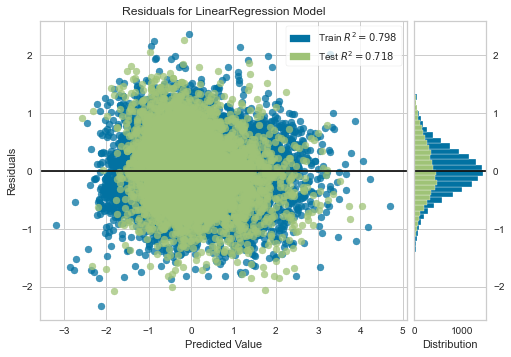

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [531]:
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
model = l_reg
visualizer = ResidualsPlot(model)

visualizer.fit(x_train_reg2, y_train_scaled)  # Fit the training data to the visualizer
visualizer.score(x_test_reg2, y_test_scaled)  # Evaluate the model on the test data
visualizer.show()  

The residuals cluster into a mostly spherical cloud like desired. There are a few outliers on the tails that deviate the mean from 0, especially for the lower fitted values. But, I already checked the extreme values in the explantory vars and there was no reason to believe these values were outside of the natual processes for these vars. Overall, I think that this is a reasonable residual plot. The residuals are normally distributed in the distribution plot on the side.

### Normality

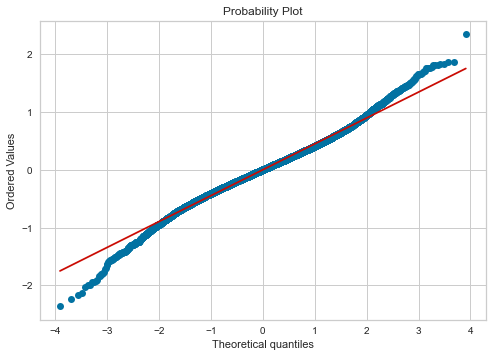

In [454]:
# Plot q-q plot of residuals
import pylab
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=pylab)
plt.show()

### Observations
- The normal probability plot above far from perfect, but it shows the residuals are approximately normally distributed.

### Predicted vs Observed

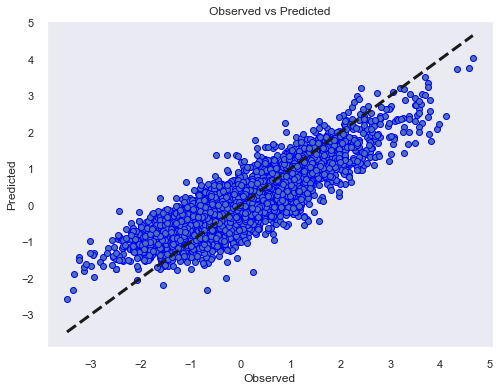

In [732]:
# Plotting observed and predicted values 
fig, ax = plt.subplots(figsize=(8, 6))
y_pred = l_reg.predict(x_test_reg2)
ax.scatter(y_test_scaled, y_pred, edgecolors=(0, 0, 1))
ax.plot([y_test_scaled.min(), y_test_scaled.max()], [y_test_scaled.min(), y_test_scaled.max()], 'k--', lw=3)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
ax.set_title("Observed vs Predicted")
plt.grid()
plt.show()

### Observations
- The plot shows that we we overpredicted for the lowest priced homes and underpredicted for the high priced homes.

### Conclusion
The OLS linear model satisfies all of the assumptions.

## Ridge Regression

Ridge regression is a regularization algorithm that reduces the chance of overfitting by biasing the model applying the L1 penalty to the original model. The result is a model with coefficients reduced towards zero, but not exactly zero, and that has high bias, but low variance. An important component of the L1 penalty is the scalar term alpha. What is the best value for alpha? GridSearchCV is applied to determine the best value for alpha.

In [455]:
# Creating the Ridge object
ridge_tuned = Ridge()

# Grid of parameters to choose from
parameters = {'alpha': np.arange(1, 10, 0.01)}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.r2_score)

# Run the grid search
grid_obj= GridSearchCV(ridge_tuned, parameters, scoring='neg_mean_squared_error', cv=5)
grid_obj = grid_obj.fit(x_train_RnL, y_train_scaled)

# Set the clf to the best combination of parameters
ridge_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
ridge_tuned.fit(x_train_RnL, y_train_scaled)

Ridge(alpha=1.1900000000000002)

In [709]:
pred_train_rnl = ridge_tuned.predict(x_train_RnL)
pred_test_rnl = ridge_tuned.predict(x_test_RnL)
pred_train = inv_transformation(pred_train_rnl, log=True, normalized=True,source=y_train_log)
pred_test = inv_transformation(pred_test_rnl, log=True, normalized=True,source=y_test_log)
##  Function to calculate r2_score and RMSE on train and test data
metrics_list = get_model_score(Y_train=y_train_scaled,Y_test=y_test_scaled, p_train=pred_train_rnl,p_test=pred_test_rnl)

R-sqaure on training set :  0.8026420362796596
R-square on test set :  0.723945446423107
RMSE on training set :  0.4442498888242298
RMSE on test set :  0.5254089393766468
MAE on training set :  0.5819111917206554
MAE on test set :  0.6446859270696119
MAPE on training set :  1.3430670947813241
MAPE on test set :  1.5276310300895897
Economic Cost on training set :  0.01622054271272895
Economic Cost on test set :  -0.059347929838770866


In [710]:
# Metrics on the reverse transformed data

##  Function to calculate r2_score and RMSE on train and test data
metrics_list = get_model_score(Y_train=y_train,Y_test=y_test, p_train=pred_train,p_test=pred_test)
store_metrics(metrics_list)

R-sqaure on training set :  0.7829038860194857
R-square on test set :  0.7350030106367794
RMSE on training set :  171214.3361574935
RMSE on test set :  188972.95853196934
MAE on training set :  315.49600296835933
MAE on test set :  339.14359597941205
MAPE on training set :  0.4281743320666672
MAPE on test set :  0.47524459052149165
Economic Cost on training set :  280878.5069193036
Economic Cost on test set :  254720.82906606342


### Observations
- The best value for alpha was 1.19.
- The model explained 78% of the variation of training's housing prices, approximately similar to the OLS linear model.
- There is no sign of overfitting in the metrics.
- The Ridge model has a smaller RMSE than the OLS linear model, meaning that the Ridge model is the best so far.

In [458]:
# Let us explore the coefficients for each of the independent attributes
for idx, col_name in enumerate(x_train_RnL.columns):
    print("The coefficient for {} is {}".format(col_name, ridge_tuned.coef_[0][idx]))

The coefficient for room_bed is -0.04654028006352154
The coefficient for room_bath is 0.07799404660998734
The coefficient for sight is 0.09328691692111904
The coefficient for condition is 0.11940511393024167
The coefficient for quality is 0.23287930119770578
The coefficient for yr_built is -0.004490492744514443
The coefficient for yr_renovated is 7.93778685266897e-05
The coefficient for lat is 0.8398140649543245
The coefficient for long is -0.5220022672094843
The coefficient for log_living_measure is 0.1796128979930314
The coefficient for log_lot_measure is 0.0454641750872246
The coefficient for log_ceil_measure is 0.11285796790856878
The coefficient for log_living_measure15 is 0.18045087408039523
The coefficient for log_lot_measure15 is -0.03643346027619597
The coefficient for ceil_1.5 is -0.07110012628580223
The coefficient for ceil_2.0 is -0.08599864612234794
The coefficient for ceil_2.5 is -0.08196755757095804
The coefficient for ceil_3.0 is -0.17035634041966646
The coefficient for

### Residuals should have mean of 0

In [459]:
# Checking that the residual mean is 0
residuals = ridge_tuned.predict(x_train_RnL)
print(f'Residual mean: {np.mean(residuals)}')

Residual mean: -3.0841377732761096e-14


The residual mean is approximately 0.

### Homoskedasticity

In [460]:
#Checking for heteroskedasticity
name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(residuals, x_train_RnL)
lzip(name, test)

[('F statistic', 1.0062476414338963), ('p-value', 0.39355441788211276)]

The test fails to reject the null hypothesis that the errors are heteroskedastic.

### Linearity

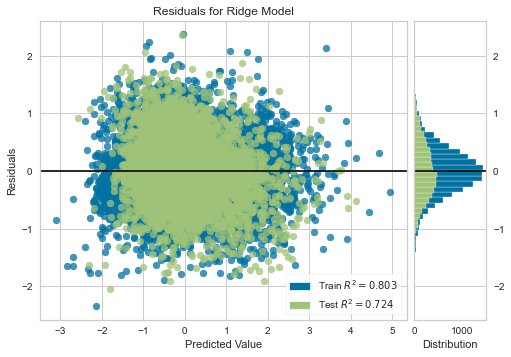

<AxesSubplot:title={'center':'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [461]:
# Instantiate the linear model and visualizer
model = ridge_tuned
visualizer = ResidualsPlot(model)

visualizer.fit(x_train_RnL, y_train_scaled)  # Fit the training data to the visualizer
visualizer.score(x_test_RnL, y_test_scaled)  # Evaluate the model on the test data
visualizer.show()  

Residual cloud like desired with a a normally distributed residual term around 0 in the side plot.

### Normality

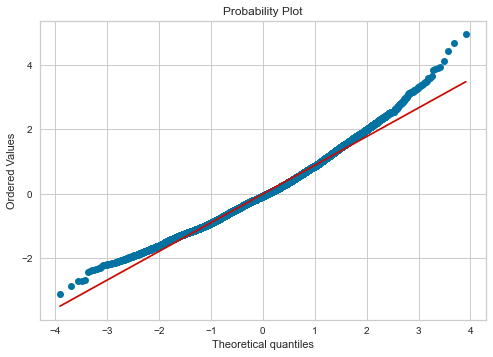

In [462]:
stats.probplot(residuals.flatten(), dist="norm", plot=pylab)
plt.show()

### Observations
- The model shows signs of non-normality on the right side tail.

### Predicted vs Observed

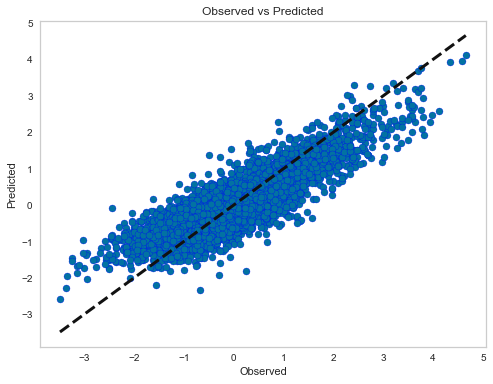

In [463]:
# Plotting observed and predicted values 
fig, ax = plt.subplots(figsize=(8, 6))
y_pred = ridge_tuned.predict(x_test_RnL)
ax.scatter(y_test_scaled, y_pred, edgecolors=(0, 0, 1))
ax.plot([y_test_scaled.min(), y_test_scaled.max()], [y_test_scaled.min(), y_test_scaled.max()], 'k--', lw=3)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
ax.set_title("Observed vs Predicted")
plt.grid()
plt.show()

### Observations
- Again, the model overpredicts the lower priced houses and underpredicts the overpriced houses.

## Lasso Regression

In [464]:
# Creating the Ridge object
lasso_tuned = Lasso()

# Grid of parameters to choose from
parameters = {'alpha': np.arange(0.1, 10, 0.01)}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.r2_score)

# Run the grid search
grid_obj= GridSearchCV(lasso_tuned, parameters, scoring='neg_mean_squared_error', cv=5)
grid_obj = grid_obj.fit(x_train_RnL, y_train_scaled)

# Set the clf to the best combination of parameters
lasso_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
lasso_tuned.fit(x_train_RnL, y_train_scaled)

Lasso(alpha=0.1)

In [711]:
pred_train_rnl = lasso_tuned.predict(x_train_RnL)
pred_test_rnl = lasso_tuned.predict(x_test_RnL)
pred_train = inv_transformation(pred_train_rnl, log=True, normalized=True,source=y_train_log)
pred_test = inv_transformation(pred_test_rnl, log=True, normalized=True,source=y_test_log)
##  Function to calculate r2_score and RMSE on train and test data
metrics_list = get_model_score(Y_train=y_train_scaled,Y_test=y_test_scaled, p_train=pred_train_rnl,p_test=pred_test_rnl)

R-sqaure on training set :  0.7021441058734572
R-square on test set :  0.624738855049096
RMSE on training set :  0.5457617558299069
RMSE on test set :  0.6125856225466804
MAE on training set :  0.6500322131823726
MAE on test set :  0.6975051302350815
MAPE on training set :  1.3720957811697518
MAPE on test set :  1.5614076043519087
Economic Cost on training set :  -0.06818053575636995
Economic Cost on test set :  -0.02449977307447958


In [712]:
# Metrics for the reverse transformed data

##  Function to calculate r2_score and RMSE on train and test data
metrics_list = get_model_score(Y_train=y_train,Y_test=y_test, p_train=pred_train,p_test=pred_test)
store_metrics(metrics_list)

R-sqaure on training set :  0.6182265184707811
R-square on test set :  0.5562618664654669
RMSE on training set :  227047.63405781268
RMSE on test set :  244535.867454023
MAE on training set :  352.3174769491871
MAE on test set :  371.8742346095329
MAPE on training set :  0.47802814998841303
MAPE on test set :  0.507029834406714
Economic Cost on training set :  278756.6612973162
Economic Cost on test set :  261760.95156887238


### Observations
- The model explained 62% of the variation in housing prices in the training data, much lower than the previous models..
- The metrics for errors are higher than the previous models.
- No signs of overfitting, though.

In [467]:
# Let us explore the coefficients for each of the independent attributes

for idx, col_name in enumerate(x_train_RnL.columns):
    print("The coefficient for {} is {}".format(col_name, lasso_tuned.coef_[idx]))

The coefficient for room_bed is 0.0
The coefficient for room_bath is 0.0
The coefficient for sight is 0.00038138603662250353
The coefficient for condition is 0.0
The coefficient for quality is 0.27323038629929614
The coefficient for yr_built is -0.0060939421949668645
The coefficient for yr_renovated is 0.00011344691277117903
The coefficient for lat is 0.3816682454324212
The coefficient for long is -0.0
The coefficient for log_living_measure is 0.25591548876309295
The coefficient for log_lot_measure is -0.0
The coefficient for log_ceil_measure is 0.0
The coefficient for log_living_measure15 is 0.057672265575375956
The coefficient for log_lot_measure15 is -0.0
The coefficient for ceil_1.5 is 0.0
The coefficient for ceil_2.0 is 0.0
The coefficient for ceil_2.5 is 0.0
The coefficient for ceil_3.0 is 0.0
The coefficient for ceil_3.5 is 0.0
The coefficient for coast_1.0 is 0.0
The coefficient for furnished_1.0 is 0.0
The coefficient for year_sold_2015 is 0.0
The coefficient for warm_month_so

### Residuals should have a mean of 0

In [468]:
# Checking the mean
prediction = lasso_tuned.predict(x_train_RnL)
residuals = (y_train_scaled.log_price - prediction)
print(f'Residual mean: {np.mean(residuals)}')

Residual mean: 3.234756489224463e-17


The residual mean is approximately 0.

### Homoeskedasticity

In [469]:
#Checking for heteroskedasticity
name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(residuals, x_train_RnL)
lzip(name, test)

[('F statistic', 0.969129012778069), ('p-value', 0.9130362812495011)]

The test fails to reject the null hypothesis that the errors are heteroskedastic.

### Linearity

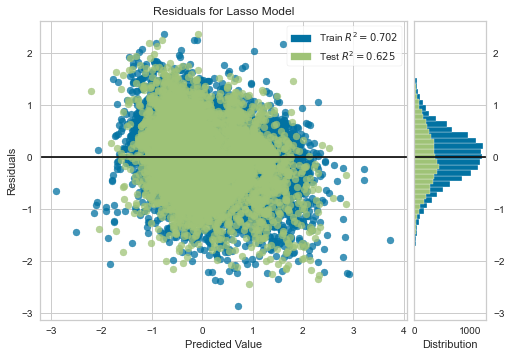

<AxesSubplot:title={'center':'Residuals for Lasso Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [470]:
# Residual plots
model = lasso_tuned
visualizer = ResidualsPlot(model)

visualizer.fit(x_train_RnL, y_train_scaled.log_price)  # Fit the training data to the visualizer
visualizer.score(x_test_RnL, y_test_scaled.log_price)  # Evaluate the model on the test data
visualizer.show()  

Residual cloud like desired in the main plot, althought it could be more circular. On the side plot, we see a approximately normally distributed residual term around 0.

### Normality

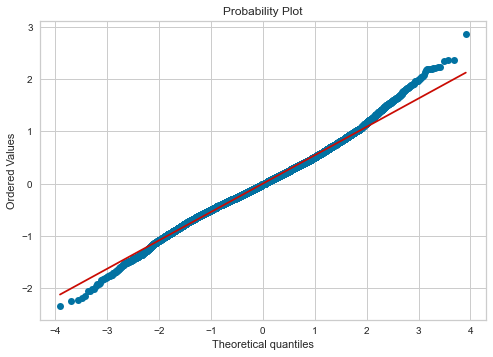

In [472]:
stats.probplot(residuals, dist="norm", plot=pylab)
plt.show()

### Observations
- As the previous models, the plot is off a bit on the tails. The model is approximately normal.

### Observed vs Predicted

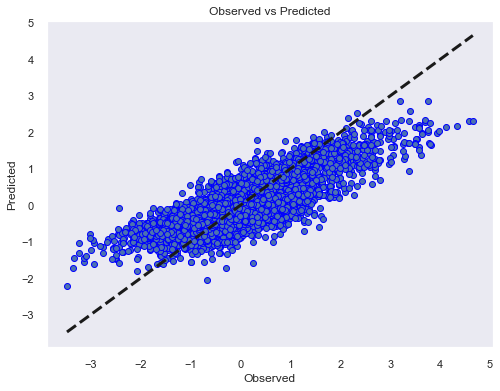

In [733]:
# Plotting observed and predicted values 
fig, ax = plt.subplots(figsize=(8, 6))
y_pred = lasso_tuned.predict(x_test_RnL)
ax.scatter(y_test_scaled, y_pred, edgecolors=(0, 0, 1))
ax.plot([y_test_scaled.min(), y_test_scaled.max()], [y_test_scaled.min(), y_test_scaled.max()], 'k--', lw=3)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
ax.set_title("Observed vs Predicted")
plt.grid()
plt.show()

### Observations
- The model is clearly biased, but Lasso regression is supposed to be biased to reduce the variance in predicting many samples.

## Random Forest

In [473]:
# Choose the type of classifier. 
rf_tuned = RandomForestRegressor(random_state=5)

# Grid of parameters to choose from
parameters = {  
                'max_depth':[4, 6, 8, 10, None],
                'max_features': ['sqrt','log2',None],
                'n_estimators': [80, 90, 100, 110, 120]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.r2_score)

# Run the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(x_train_xg, y_train_xg)

# Set the clf to the best combination of parameters
rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
rf_tuned.fit(x_train_xg, y_train_xg)

RandomForestRegressor(max_features=None, n_estimators=110, random_state=5)

In [713]:
pred_train_rf = rf_tuned.predict(x_train_xg)
pred_test_rf = rf_tuned.predict(x_test_xg)
pred_train = inv_transformation(pred_train_rf, normalized=True,source=y_train)
pred_test = inv_transformation(pred_test_rnl, normalized=True,source=y_test)
##  Function to calculate r2_score and RMSE on train and test data
metrics_list = get_model_score(Y_train=y_train_xg,Y_test=y_test_xg, p_train=pred_train_rf,p_test=pred_test_rf)

R-sqaure on training set :  0.9713740650735649
R-square on test set :  0.8166702927854737
RMSE on training set :  0.16919200609495416
RMSE on test set :  0.42817018487340563
MAE on training set :  0.3056271897310597
MAE on test set :  0.49382532949768837
MAPE on training set :  0.7878210735057669
MAPE on test set :  1.4897609829997753
Economic Cost on training set :  -0.06712243643452027
Economic Cost on test set :  0.016712720754685433


In [714]:
# Metrics for the reverse transformed data

##  Function to calculate r2_score and RMSE on train and test data
metrics_list =get_model_score(Y_train=y_train,Y_test=y_test, p_train=pred_train,p_test=pred_test)
store_metrics(metrics_list)

R-sqaure on training set :  0.9713770047634076
R-square on test set :  0.5617926273613455
RMSE on training set :  62168.67919019812
RMSE on test set :  243007.1390417179
MAE on training set :  185.263057140273
MAE on test set :  375.06326957937955
MAPE on training set :  0.2538684704374979
MAPE on test set :  0.5258444751442147
Economic Cost on training set :  265497.553027732
Economic Cost on test set :  303250.18670790346


### Observations
- The model does a great job on the training data, but the metrics show heavy overfitting when the model is applied to the test data. This model would not be useful in production.

## AdaBoost

In [476]:
# Choose the type of classifier. 
ad_tuned = AdaBoostRegressor(random_state=5)

# Grid of parameters to choose from
parameters = {'n_estimators': np.arange(10,100,10), 
              'learning_rate': np.arange(0.01,1,0.1),
              }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.r2_score)

# Run the grid search
grid_obj = GridSearchCV(ad_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(x_train_xg, y_train_xg)

# Set the clf to the best combination of parameters
ad_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
ad_tuned.fit(x_train_xg, y_train_xg)

AdaBoostRegressor(learning_rate=0.31000000000000005, n_estimators=20,
                  random_state=5)

In [715]:
##  Function to calculate r2_score and RMSE on train and test data
pred_train_ada = ad_tuned.predict(x_train_xg)
pred_test_ada = ad_tuned.predict(x_test_xg)
pred_train = inv_transformation(pred_train_ada, normalized=True,source=y_train)
pred_test = inv_transformation(pred_test_ada, normalized=True,source=y_test)
##  Function to calculate r2_score and RMSE on train and test data
metrics_list = get_model_score(Y_train=y_train_xg,Y_test=y_test_xg, p_train=pred_train_ada,p_test=pred_test_ada)

R-sqaure on training set :  0.6631270298660847
R-square on test set :  0.6409074990869514
RMSE on training set :  0.580407589659125
RMSE on test set :  0.5992432735651261
MAE on training set :  0.6397872922060861
MAE on test set :  0.639628462319425
MAPE on training set :  1.5205417964334254
MAPE on test set :  1.7484623874057734
Economic Cost on training set :  -0.06107005931732684
Economic Cost on test set :  -0.056621508191252244


In [716]:
# Metrics for the reverse transformed data

##  Function to calculate r2_score and RMSE on train and test data
metrics_list =get_model_score(Y_train=y_train,Y_test=y_test, p_train=pred_train,p_test=pred_test)
store_metrics(metrics_list)

R-sqaure on training set :  0.6631267934260567
R-square on test set :  0.64090496639373
RMSE on training set :  213278.6272175183
RMSE on test set :  219980.35155938612
MAE on training set :  387.8308875367581
MAE on test set :  387.54044165290907
MAPE on training set :  0.5821657392348406
MAPE on test set :  0.5798965342789075
Economic Cost on training set :  344407.69711786916
Economic Cost on test set :  344159.741295529


### Observations
- This model shows no sign of overfitting.
- the r-square and RMSE metrics are weaker than the OLS and Ridge models that have been the best so far.

## GradientBoost

In [479]:
# Choose the type of classifier. 
gb_tuned = GradientBoostingRegressor(random_state=1)

# Grid of parameters to choose from
parameters = {'n_estimators': np.arange(50,200,25), 
              'subsample':[0.5,0.7,0.8,0.9,1],
              'max_features':[0.5,0.7,0.8,0.9,1],
              'max_depth':[3,5,7,10]
              }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.r2_score)

# Run the grid search
grid_obj = GridSearchCV(gb_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(x_train_xg, y_train_xg)

# Set the clf to the best combination of parameters
gb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
gb_tuned.fit(x_train_xg, y_train_xg)

GradientBoostingRegressor(max_depth=7, max_features=0.5, n_estimators=150,
                          random_state=1, subsample=0.9)

In [717]:
##  Function to calculate r2_score and RMSE on train and test data
pred_train_gb = gb_tuned.predict(x_train_xg)
pred_test_gb = gb_tuned.predict(x_test_xg)
pred_train = inv_transformation(pred_train_gb, normalized=True,source=y_train)
pred_test = inv_transformation(pred_test_gb, normalized=True,source=y_test)
##  Function to calculate r2_score and RMSE on train and test data
metrics_list = get_model_score(Y_train=y_train_xg,Y_test=y_test_xg, p_train=pred_train_gb,p_test=pred_test_gb)

R-sqaure on training set :  0.952442000657079
R-square on test set :  0.816138547399174
RMSE on training set :  0.21807796620227607
RMSE on test set :  0.4287906862337683
MAE on training set :  0.3975371269951962
MAE on test set :  0.49883696106455927
MAPE on training set :  1.1342044684408048
MAPE on test set :  1.438907279408837
Economic Cost on training set :  -0.033287625633552045
Economic Cost on test set :  0.030409926979106855


In [718]:
# Metrics for the reverse transformed data

##  Function to calculate r2_score and RMSE on train and test data
metrics_list =get_model_score(Y_train=y_train,Y_test=y_test, p_train=pred_train,p_test=pred_test)
store_metrics(metrics_list)

R-sqaure on training set :  0.952443437516542
R-square on test set :  0.8161381317482216
RMSE on training set :  80134.46264365243
RMSE on test set :  157407.35698563536
MAE on training set :  240.98040075759545
MAE on test set :  302.2395617783653
MAPE on training set :  0.35648789605100234
MAPE on test set :  0.41564814303152403
Economic Cost on training set :  269182.0789240855
Economic Cost on test set :  281746.3383317688


### Observations
- The r-square and RMSE metrics are the best so far.
- There is some sign of overfitting, but the model still appears to be very useful.

## Observed vs Predicted

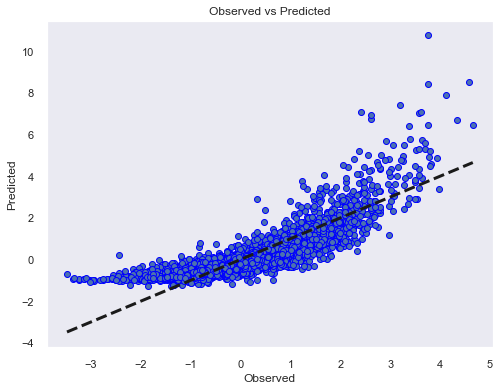

In [736]:
# Plotting observed and predicted values 
fig, ax = plt.subplots(figsize=(8, 6))
y_pred = gb_tuned.predict(x_test_xg)
ax.scatter(y_test_scaled, y_pred, edgecolors=(0, 0, 1))
ax.plot([y_test_scaled.min(), y_test_scaled.max()], [y_test_scaled.min(), y_test_scaled.max()], 'k--', lw=3)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
ax.set_title("Observed vs Predicted")
plt.grid()
plt.show()

### Observations
- This model over predicts for both the lower and higher priced homes. 
- For higest priced homes, the predictions look random.

## XGBoost

In [483]:
# Choose the type of classifier. 
xgb_tuned = XGBRegressor(random_state=1)

# Grid of parameters to choose from
parameters = {'n_estimators': np.arange(50,200,25), 
              'subsample':[0.5,0.7, 0.8, 0.9, 1],
              'gamma':[0, 1, 3, 5],
              'colsample_bytree':[0.5,0.7, 0.8, 0.9, 1],
              'colsample_bylevel':[0.5,0.7, 0.8, 0.9, 1]
              }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.r2_score)

# Run the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(x_train_xg, y_train_xg)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
xgb_tuned.fit(x_train_xg, y_train_xg)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=1, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=125, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=1, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [719]:
##  Function to calculate r2_score and RMSE on train and test data
pred_train_xg = xgb_tuned.predict(x_train_xg)
pred_test_xg = xgb_tuned.predict(x_test_xg)
pred_train = inv_transformation(pred_train_xg, normalized=True,source=y_train)
pred_test = inv_transformation(pred_test_xg, normalized=True,source=y_test)
##  Function to calculate r2_score and RMSE on train and test data
metrics_list = get_model_score(Y_train=y_train_xg,Y_test=y_test_xg, p_train=pred_train_xg,p_test=pred_test_xg)


R-sqaure on training set :  0.9218389746004473
R-square on test set :  0.8071367445109984
RMSE on training set :  0.27957293395383015
RMSE on test set :  0.43916199230921793
MAE on training set :  0.44558687387504226
MAE on test set :  0.5069836394288172
MAPE on training set :  1.255225318686094
MAPE on test set :  1.4304257414080686
Economic Cost on training set :  -0.005338794329396575
Economic Cost on test set :  0.0423194473018027


In [720]:
# Metrics for the reverse transformed data

##  Function to calculate r2_score and RMSE on train and test data
metrics_list =get_model_score(Y_train=y_train,Y_test=y_test, p_train=pred_train,p_test=pred_test)
store_metrics(metrics_list)

R-sqaure on training set :  0.9218401659660709
R-square on test set :  0.8071349739820859
RMSE on training set :  102732.0408386038
RMSE on test set :  161215.1799968381
MAE on training set :  270.1089991194111
MAE on test set :  307.1760630127583
MAPE on training set :  0.3935431165293283
MAPE on test set :  0.4225093651363166
Economic Cost on training set :  278946.31908673205
Economic Cost on test set :  279705.1183318584


### Observations
- The r-square and RMSE metrics are good relative to most of the models with GradientBoost still doing slightly better.
- As with the previous model, there is some sign of overfitting on the training data. However, the model is still bery useful.

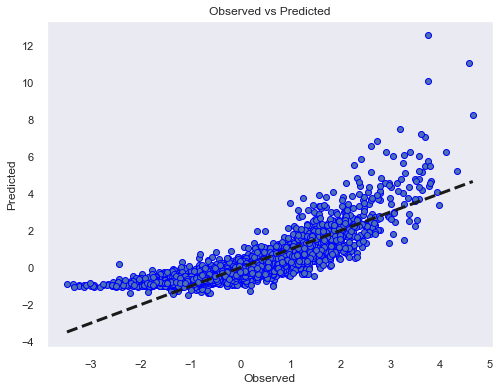

In [738]:
# Plotting observed and predicted values 
fig, ax = plt.subplots(figsize=(8, 6))
y_pred = xgb_tuned.predict(x_test_xg)
ax.scatter(y_test_scaled, y_pred, edgecolors=(0, 0, 1))
ax.plot([y_test_scaled.min(), y_test_scaled.max()], [y_test_scaled.min(), y_test_scaled.max()], 'k--', lw=3)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
ax.set_title("Observed vs Predicted")
plt.grid()
plt.show()

### Observations
- This model over predicts for both the lower and higher priced homes. 
- For higest priced homes, the predictions look random.

## Model Comparison

In [721]:
comparison_frame = pd.DataFrame({'Model':['Naive Mean','OLS Regression','Tuned Ridge Regression','Tuned Lasso Regression',
                                          'Tuned Random Forest','AdaBoost','Tuned_GradientBoost',
                                          'Tuned XGBoost Regressor'], 
                                          'Train_r2': r2_train,'Test_r2': r2_test,
                                          'Train_RMSE':rmse_train,'Test_RMSE':rmse_test,
                                          'Train_MAE':mae_train,'Test_MAE':mae_test,
                                          'Train_MAPE':mape_train,'Test_MAPE':mape_test,
                                          'Train_Econ_Cost':econ_train,'Test_Econ_Cost':econ_test}) 
comparison_frame

,Model,Train_r2,Test_r2,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_MAPE,Test_MAPE,Train_Econ_Cost,Test_Econ_Cost
0,Naive Mean,-1.225,-1.233,548140.141,548531.075,735.273,735.544,1.139,1.140,540625.886,541024.386
1,OLS Regression,0.770,0.725,176139.527,192470.526,318.553,340.979,0.431,0.478,282935.405,258491.796
2,Tuned Ridge Regression,0.783,0.735,171214.336,188972.959,315.496,339.144,0.428,0.475,280878.507,254720.829
3,Tuned Lasso Regression,0.618,0.556,227047.634,244535.867,352.317,371.874,0.478,0.507,278756.661,261760.952
4,Tuned Random Forest,0.971,0.562,62168.679,243007.139,185.263,375.063,0.254,0.526,265497.553,303250.187
5,AdaBoost,0.663,0.641,213278.627,219980.352,387.831,387.540,0.582,0.580,344407.697,344159.741
6,Tuned_GradientBoost,0.952,0.816,80134.463,157407.357,240.980,302.240,0.356,0.416,269182.079,281746.338
7,Tuned XGBoost Regressor,0.922,0.807,102732.041,161215.180,270.109,307.176,0.394,0.423,278946.319,279705.118


### Observations
- GradientBoost and the XGBoost algorithms have the best metrics for the combination of both train and test data sets (Random Forest did well only on training data).
- The models that showed the least signs of overfitting, OLS, Ridge, Lasso, and AdaBoost, still have much higher error metrics.
- The XGBoost regressor model is the best model for this case as the GraidentBoost shows more signs of overfitting the training data.

## Feature Importance

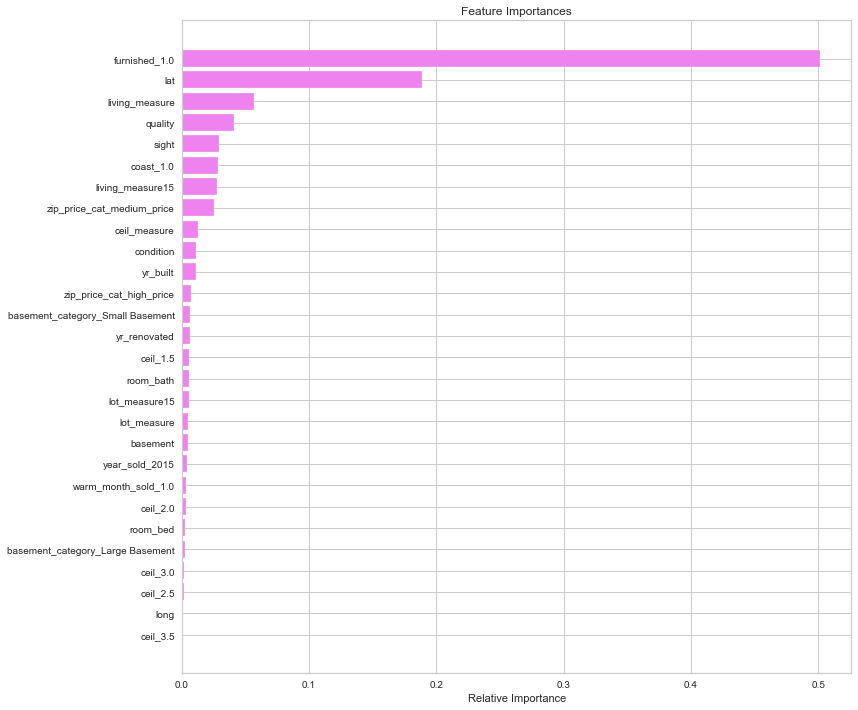

In [546]:
feature_names = x_train_xg.columns
importances = xgb_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Observations
- According to the model, a house being furnished was extremely influential on the expected house price. 
- Houses further north in King County, WA were predicted to have a higher price. 
- As one would expect, having a higher quality score, viewed more often, a coastal view, and bigger living area are expected to sell for more. 
- Surprisingly, a house in a zip code with medium average price is predicted to have a lower price than a house in a zip code with low average price houses (This negative association was gleaned from looking at the variable's coefficient in the OLS and Ridge regressions). 

## Insights and Recommendations:

- For sellers, there is nothing that they can do to influence the variables related to location as that is fixed for them. Fortunately, offering a furnished home is the most influential variable and completely within their control. Sellers can also make renovations to increase their living area and/or to bring up quality scores or maintain. 
- For buyers looking for lower prices but not wanting lower quality homes, they can go after homes in the southern section of King County, WA with smaller living areas, and avoid houses with a coastal view, look in zip codes with lower price averages.

## Comments Future Analysis

I also tried using K-Means clustering to find groups based on location in place of zipcodes. This model performed slightly worse. Another possibility is to get GPS coordinates for local schools, hospitals, fire departments, etc. and calculate each house distance to the nearest location of each type of institution. If that fails, I may have to use a seperate model to estimate the houses with the greatest residuals.

# Conclusion

The XGBoost model is the best model for predicting prices in King County, Washington with a test r-square of 0.82 and RMSE of \\$161,215. Houses with higher prices were associated with being furnished, in the northern part of the county, larger living areas, higher quality scores, a coastal view, more views, and outside of areas with medium price averages. These features can help sellers act to increase their house prices and buyers know what to consider when looking for lower prices.